## **IRIS spectral analysis tutorial for raster data** ##
This is written by Dr. Sargam Mulay, University of Glasgow, UK


The Interface Region Imaging Spectrograph (IRIS) is a NASA satellite designed for solar observation.

There are two instruments onboard IRIS satellite - Slit Jaw Imager (SJI) and Spectrograph

• The IRIS was launched in July 2013 to study the chromosphere and transition region \
• Provides simultaneous images and spectra \
• Far-UV: 1331.56 - 1358.40 & 1390.00 - 1406.79 Å \
• Near-UV: 2782.56 - 2833.89 Å \
• Temporal resolution: 2 sec \
• Spatial resolution: 1 pixel = 0.33" = 241.76 km \
• Spectral resolution: 26 mÅ (FUV), 53 mÅ (NUV) \
• Temperature: between 5000 K to 10 MK \
• Spectrograph slit movement: Solar East to West (in the same direction as the solar rotation) \
• Observation modes for spectrograph: raster and sit-and-stare mode 


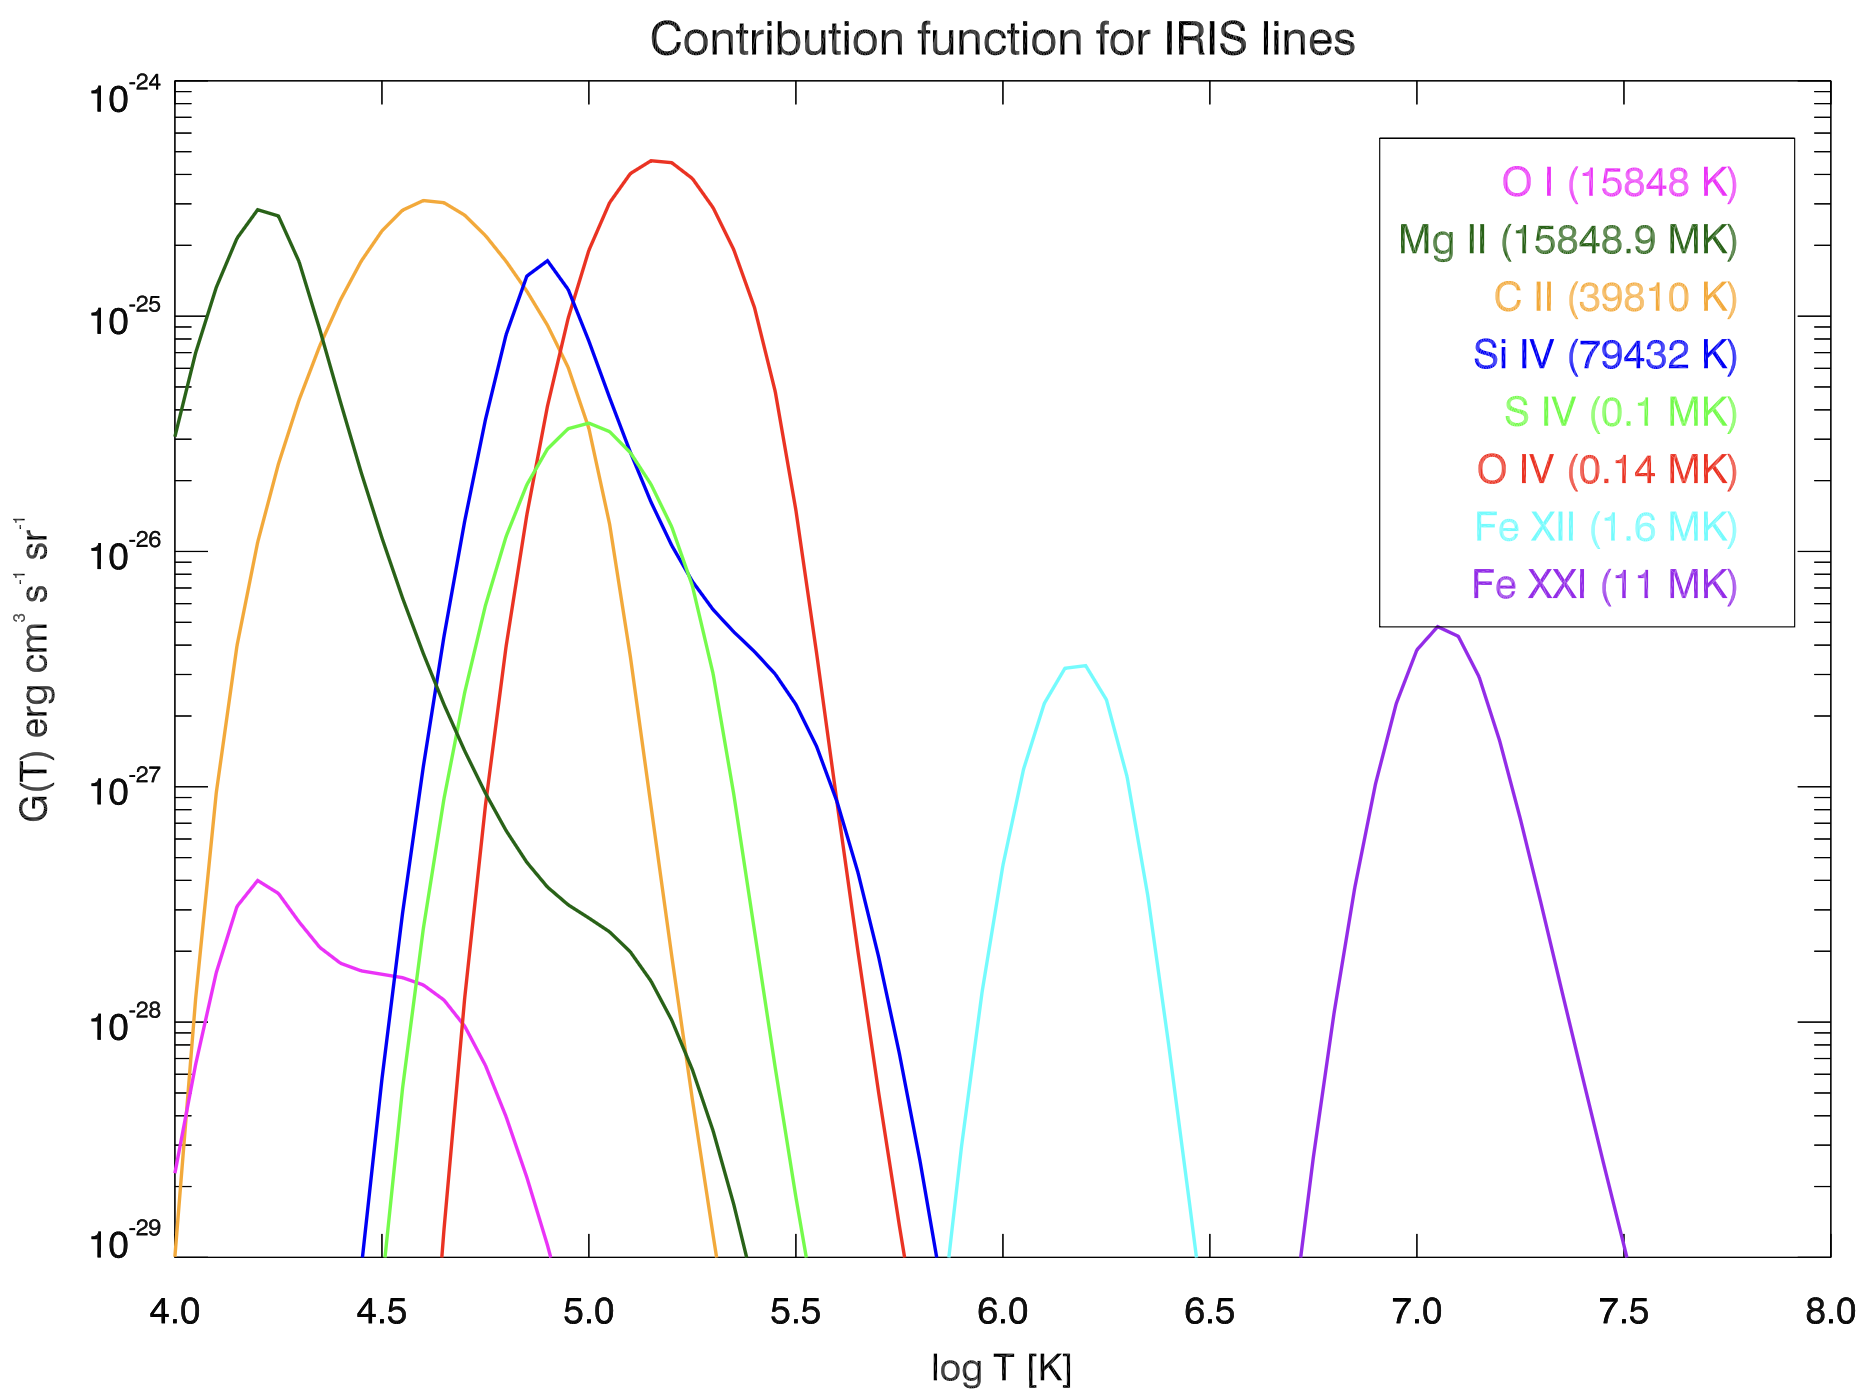

In [4]:
# importing relevant modules and packages

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.patches import Rectangle as rect
from matplotlib import gridspec
import matplotlib.ticker as ticker
%matplotlib inline
from matplotlib.ticker import AutoMinorLocator
import matplotlib.dates as dates

import numpy as np
import numpy.ma as ma
import os, time

import astropy.units as u
from astropy.coordinates import SpectralCoord
from astropy.io import fits
from astropy.visualization import (time_support, MinMaxInterval, SqrtStretch, ImageNormalize)
from astropy.wcs import WCS
from astropy.modeling import models

import requests
import inspect
from datetime import datetime, timedelta

import scipy as scipy
from scipy import stats
from scipy import optimize
from scipy.constants import c
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from scipy import interpolate

#from irispy.io import read_spectrograph_lvl2
#from irispy.io import read_sji_lvl2
#from irispy.utils import image_clipping
#from irispy.utils.utils import _download_data

from specutils.spectra import Spectrum1D
from specutils.fitting import fit_lines

from lmfit.models import GaussianModel, ConstantModel
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd

%matplotlib inline

# function to convert to superscript 
def get_super(x): 
    normal = "ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789+-=()"
    super_s = "ᴬᴮᶜᴰᴱᶠᴳᴴᴵᴶᴷᴸᴹᴺᴼᴾQᴿˢᵀᵁⱽᵂˣʸᶻᵃᵇᶜᵈᵉᶠᵍʰᶦʲᵏˡᵐⁿᵒᵖ۹ʳˢᵗᵘᵛʷˣʸᶻ⁰¹²³⁴⁵⁶⁷⁸⁹⁺⁻⁼⁽⁾"
    res = x.maketrans(''.join(normal), ''.join(super_s)) 
    return x.translate(res) 
# display superscipt 
# print(get_super('GeeksforGeeks')) #ᴳᵉᵉᵏˢᶠᵒʳᴳᵉᵉᵏˢ 


# function to convert to subscript 
def get_sub(x): 
    normal = "ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789+-=()"
    sub_s = "ₐ₈CDₑբGₕᵢⱼₖₗₘₙₒₚQᵣₛₜᵤᵥwₓᵧZₐ♭꜀ᑯₑբ₉ₕᵢⱼₖₗₘₙₒₚ૧ᵣₛₜᵤᵥwₓᵧ₂₀₁₂₃₄₅₆₇₈₉₊₋₌₍₎"
    res = x.maketrans(''.join(normal), ''.join(sub_s)) 
    return x.translate(res) 
  
# display subscript 
#print('H{}SO{}'.format(get_sub('2'),get_sub('4'))) #H₂SO₄ 

## Angstrom symbol in print command
# print('wavelength \u00c5')

# subscript for H2
# H\N{SUBSCRIPT TWO}

#plt.style.use('untitled1.txt')

plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['image.origin'] = 'lower' # this is important to convert the Y-axis ticks - starting at the bottom left
plt.rcParams['image.cmap'] = 'viridis'



## **IRIS raster data is available at** ##
- https://www.lmsal.com/hek/hcr?cmd=view-event&event-id=ivo%3A%2F%2Fsot.lmsal.com%2FVOEvent%23VOEvent_IRIS_20140211_163401_3880012191_2014-02-11T16%3A34%3A012014-02-11T16%3A34%3A01.xml



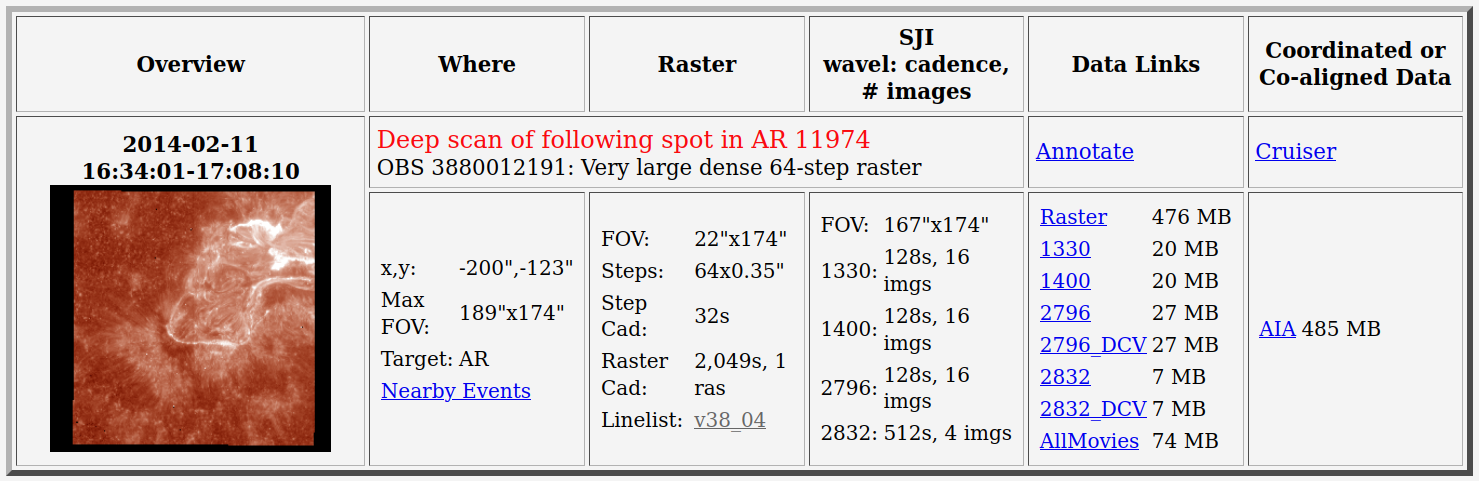


## **IRIS FTP data download** ##
- https://umbra.nascom.nasa.gov/iris/

## **IRISpy tutorial** ##
- https://iris.lmsal.com/itn41/reading_iris.html 
- https://github.com/tiagopereira/iris_tutorials/blob/master/notebooks/IRIS10.ipynb 
- https://www2.mps.mpg.de/meetings/iris9/abs/tut%202.pdf 
- https://github.com/DanRyanIrish/irispy_tutorials/blob/master/irispy_demo_iris9/irispy_demo_iris9.ipynb 
- https://github.com/abit2/irispy/tree/master/irispy 
- https://arxiv.org/pdf/2011.12139.pdf 

## **irispy-lmsal tutorial** ##
- https://iris.lmsal.com/itn45/chapter2.html#a-quick-look-at-iris-level-2-data




## **Reading in an IRIS raster file** ##

In [5]:
def fits_reader(path):
    spectra = fits.open(path)
    header = spectra[0].header
    return spectra, header

In [6]:
sp, hdr = fits_reader(path=r'/Users/sargammulay/Desktop/python/IRIS_python_tutorial/iris_l2_20140211_163401_3880012191_raster_t000_r00000.fits')

In [7]:
# Check what kind of raster it is (should be Very Very large dense 64-step raster)

print('IRIS observation date - ', hdr['DATE_OBS'])
print('IRIS observation information - ', hdr['OBS_DESC'])


IRIS observation date -  2014-02-11T16:34:01.711
IRIS observation information -  Very large dense 64-step raster 20.8x175 64s  C II   Si IV   Mg II h


## **Check Header information** ##

#### Keyword meanings available for download at https://iris.lmsal.com/itn26/iris_level2.html ####
#### https://www.lmsal.com/iris_science/doc?cmd=dcur&proj_num=IS0211&file_type=pdf ####



IRIS has multiple headers of which the first header (should be access with index zero) is a long header that contains information of all the windows observed

In [8]:
# Check the big header

iris_big_header = sp[0].header
print(iris_big_header)

SIMPLE  =                    T / Written by IDL:  Thu Jun  1 18:06:19 2017      BITPIX  =                   16 / Number of bits per data pixel                  NAXIS   =                    0 / Number of data axes                            EXTEND  =                    T / FITS data may contain extensions               DATE    = '2017-06-02'         / Creation UTC (CCCC-MM-DD) date of FITS header  COMMENT FITS (Flexible Image Transport System) format is defined in 'Astronomy  COMMENT and Astrophysics', volume 376, page 359; bibcode 2001A&A...376..359H    TELESCOP= 'IRIS    '           /                                                INSTRUME= 'SPEC    '           /                                                DATA_LEV=              2.00000 /                                                LVL_NUM =              2.00000 /                                                VER_RF2 = 'L12-2017-04-23'     /                                                DATE_RF2= '2017-06-02T00:54:49.444' /   

 [astropy.io.fits.verify]


In [9]:
Num_win = iris_big_header['NWIN']
print('No. of windows = ', Num_win)

FOV_X = iris_big_header['FOVX']
print('Field-of-view in X-direction (arcsec) = ', FOV_X)

FOV_Y = iris_big_header['FOVY']
print('Field-of-view in Y-direction (arcsec) = ', FOV_Y)

N_EXP = iris_big_header['NEXP']
print('No. of exposures = ', N_EXP)

EXP_TIME = iris_big_header['EXPTIME']
print('Exposure time = ', EXP_TIME)


No. of windows =  3
Field-of-view in X-direction (arcsec) =  22.1886253357
Field-of-view in Y-direction (arcsec) =  181.654
No. of exposures =  64
Exposure time =  29.9988


## **Examine how many windows are available in the raster scan** ##

This observation has three windows.


In [10]:
Num_win = iris_big_header['NWIN']
print('No. of windows in the raster file = ', Num_win)
print('')
print('Window Name       : wave start - wave end\n')
for i in range(hdr['NWIN']):
 win = str(i + 1)
 print('{0}. {1:15}: {2:.2f} - {3:.2f} Å'
 ''.format(win, hdr['TDESC' + win], hdr['TWMIN' + win], hdr['TWMAX' + win]))

No. of windows in the raster file =  3

Window Name       : wave start - wave end

1. C II 1336      : 1331.68 - 1358.38 Å
2. Si IV 1394     : 1380.69 - 1406.79 Å
3. Mg II k 2796   : 2783.13 - 2835.02 Å


## **Information about window 1 - C II** ##

In [11]:
# We are accesing information from iris_big_header i.e. from sp[0].header
# The wavelength information from each window has been stored as TWMIN1, TWMAX1 
# the number indicates the window number

print('Win 1 min_wavelength =', iris_big_header['TWMIN1'], 'Å')
print('Win 1 max_wavelength =', iris_big_header['TWMAX1'], 'Å')
print('')
print('')

print('We are accesing information from other available headers for each window i.e. from sp[1].header')
print('')
print('Header for window 1 = C II 1336 Å')

win1_c2_header = sp[1].header
print(win1_c2_header)


Win 1 min_wavelength = 1331.68328015 Å
Win 1 max_wavelength = 1358.38314039 Å


We are accesing information from other available headers for each window i.e. from sp[1].header

Header for window 1 = C II 1336 Å
XTENSION= 'IMAGE   '           / IMAGE extension                                BITPIX  =                   16 / Number of bits per data pixel                  NAXIS   =                    3 / Number of data axes                            NAXIS1  =                 2058 /                                                NAXIS2  =                 1092 /                                                NAXIS3  =                   64 /                                                PCOUNT  =                    0 / No Group Parameters                            GCOUNT  =                    1 / One Data Group                                 BSCALE  =                 0.25 /                                                BZERO   =                 7992 /                                     

## **Information about window 2 -  Si IV** ##

In [12]:
# We are accesing information from iris_big_header i.e. from sp[0].header
# The wavelength information from each window has been stored as TWMIN2, TWMAX2 - the number indicates the window number

print('Win 2 min_wavelength =', iris_big_header['TWMIN2'],'Å')
print('Win 2 max_wavelength =', iris_big_header['TWMAX2'],'Å')
print('')
print('')

print('We are accesing information from other available headers for each window i.e. from sp[2].header')
print('')
print('Header for window 2 = Si IV 1394 Å')

win2_si4_header = sp[2].header
print(win2_si4_header)


Win 2 min_wavelength = 1380.68938787 Å
Win 2 max_wavelength = 1406.79082787 Å


We are accesing information from other available headers for each window i.e. from sp[2].header

Header for window 2 = Si IV 1394 Å
XTENSION= 'IMAGE   '           / IMAGE extension                                BITPIX  =                   16 / Number of bits per data pixel                  NAXIS   =                    3 / Number of data axes                            NAXIS1  =                 2053 /                                                NAXIS2  =                 1092 /                                                NAXIS3  =                   64 /                                                PCOUNT  =                    0 / No Group Parameters                            GCOUNT  =                    1 / One Data Group                                 BSCALE  =                 0.25 /                                                BZERO   =                 7992 /                                    

## **Check the size of the spectral data array** ##

In [13]:
win1_c2_sp_data = sp[1].data
print(win1_c2_sp_data.shape, '(time, pixel, wavelength)')

(64, 1092, 2058) (time, pixel, wavelength)


Here NAXIS1=2058 (wavelength), NAXIS2=1092, (spatial y), and NAXIS3=64 (time). Since arrays in Python are in C order, the dimension order will be reversed.

So the data shape will be in (time, pixel, wavelength) order.

## **Access individual dimension from the spectral data** ##
This is useful syntax to access each dimension separately and check the number of elements in each dimension. This could be stored as an individual variables.

In [14]:
win1_sp_N_slit = win1_c2_sp_data.shape[0]
print('No. of slit positions (or exposures) along X-axis = ', win1_sp_N_slit)
print('')

win1_sp_N_Ypix = win1_c2_sp_data.shape[1]
print('No. of pixels along Y-axis = ', win1_sp_N_Ypix)
print('')

win1_sp_N_wave = win1_c2_sp_data.shape[2]
print('No. of wavelengths = ', win1_sp_N_wave)
print('')


No. of slit positions (or exposures) along X-axis =  64

No. of pixels along Y-axis =  1092

No. of wavelengths =  2058



## **Creating wavelength array for window 1 = C II 1336 using WCS routines - Method 1** ##

In [15]:
wcs1 = WCS(win1_c2_header) # wcs1 = WCS(sp[1].header)
print('wcs1 =',wcs1)

m_to_angstrom = 1e10 # meter to Angstrom conversion factor
win1_n_wavelength = win1_c2_sp_data.shape[2] # nwave1 = sp[1].data.shape[2]
print('Win 1 size of wavelength array = ', win1_n_wavelength)
print('')
win1_c2_wavelength_WCS = wcs1.all_pix2world(np.arange(win1_n_wavelength), [0.], [0.], 0)[0] * m_to_angstrom
print(win1_c2_wavelength_WCS)

wcs1 = WCS Keywords

Number of WCS axes: 3
CTYPE : 'WAVE' 'HPLT-TAN' 'HPLN-TAN' 
CRVAL : 1.33168328015e-07 -0.034104722222222224 -0.054634166666666664 
CRPIX : 1.0 546.5 32.0 
PC1_1 PC1_2 PC1_3  : 1.0 0.0 0.0 
PC2_1 PC2_2 PC2_3  : 0.0 0.999988496304 -0.023666474931 
PC3_1 PC3_2 PC3_3  : 0.0 0.00537063565863 0.999988496304 
CDELT : 1.29800001159e-12 4.620833333333333e-05 9.700056526805556e-05 
NAXIS : 2058  1092  64
Win 1 size of wavelength array =  2058

[1331.68328015 1331.69626015 1331.70924015 ... 1358.35718039 1358.37016039
 1358.38314039]


## **Creating wavelength array for window 1  = C II from header info - Method 2** ##

If the WCS syntax in above cell doesn't work then you can create wavelength array using the following syntax.

In [16]:
# Here win1_header = sp[1].header

win1_c2_wavelength = (np.arange(0, win1_c2_header['NAXIS1']) - win1_c2_header['CRPIX1']+1)*win1_c2_header['CDELT1'] + win1_c2_header['CRVAL1']
win1_c2_wavelength

array([1331.68328015, 1331.69626015, 1331.70924015, ..., 1358.35718039,
       1358.37016039, 1358.38314039])

## **Creating wavelength array for window 1 = C II - Method 3** ## 

In [17]:
# Here iris_big_header = sp[0].header

def get_wavelengths(data, hdr): # for plots
    nwave = win1_c2_sp_data.shape[2]
    min_wl = iris_big_header['TWMIN1'] # 0th spectral window
    max_wl = iris_big_header['TWMAX1']

    interval = (max_wl-min_wl)/nwave
    wavelengths = np.arange(min_wl, max_wl, interval)
    return wavelengths

In [18]:
win1_c2_sp_wavelength = get_wavelengths(win1_c2_sp_data, hdr)
print('wavelength array dimention = ', win1_c2_sp_wavelength.shape)
print(win1_c2_sp_wavelength)

wavelength array dimention =  (2058,)
[1331.68328015 1331.69625384 1331.70922754 ... 1358.34421931 1358.357193
 1358.3701667 ]


## **Creating wavelength array for window 2 = Si IV from header info - Method 2** ##


In [19]:
win2_si4_header = sp[2].header

win2_si4_wavelength = (np.arange(0, win2_si4_header['NAXIS1']) - win2_si4_header['CRPIX1']+1)*win2_si4_header['CDELT1'] + win2_si4_header['CRVAL1']
win2_si4_wavelength

array([1380.68938787, 1380.70210787, 1380.71482787, ..., 1406.76538787,
       1406.77810787, 1406.79082787])

## **Converting the X-axis slit numbers to time in UT** ##

In [20]:
time_diff = sp[-2].data[:, sp[-2].header['TIME']]
time_diff

array([1.710000e-01, 3.218100e+01, 6.404100e+01, 9.624100e+01,
       1.280910e+02, 1.602710e+02, 1.921210e+02, 2.241210e+02,
       2.561510e+02, 2.883410e+02, 3.201710e+02, 3.521810e+02,
       3.842110e+02, 4.164010e+02, 4.482110e+02, 4.802410e+02,
       5.125710e+02, 5.446210e+02, 5.764610e+02, 6.086510e+02,
       6.405010e+02, 6.726810e+02, 7.044710e+02, 7.365210e+02,
       7.685610e+02, 8.007410e+02, 8.325710e+02, 8.645910e+02,
       8.966210e+02, 9.288010e+02, 9.606210e+02, 9.926510e+02,
       1.024981e+03, 1.057021e+03, 1.088871e+03, 1.121061e+03,
       1.152901e+03, 1.185091e+03, 1.216931e+03, 1.248961e+03,
       1.280961e+03, 1.313151e+03, 1.344971e+03, 1.377031e+03,
       1.409021e+03, 1.441211e+03, 1.473061e+03, 1.505091e+03,
       1.537401e+03, 1.569431e+03, 1.601291e+03, 1.633461e+03,
       1.665301e+03, 1.697491e+03, 1.729341e+03, 1.761371e+03,
       1.793371e+03, 1.825561e+03, 1.857371e+03, 1.889431e+03,
       1.921431e+03, 1.953621e+03, 1.985401e+03, 2.0174

In [21]:
time_diff = sp[-2].data[:, sp[-2].header['TIME']]
times = np.datetime64(hdr['DATE_OBS']) + time_diff * np.timedelta64(1, 's')

times

array(['2014-02-11T16:34:01.711', '2014-02-11T16:34:33.711',
       '2014-02-11T16:35:05.711', '2014-02-11T16:35:37.711',
       '2014-02-11T16:36:09.711', '2014-02-11T16:36:41.711',
       '2014-02-11T16:37:13.711', '2014-02-11T16:37:45.711',
       '2014-02-11T16:38:17.711', '2014-02-11T16:38:49.711',
       '2014-02-11T16:39:21.711', '2014-02-11T16:39:53.711',
       '2014-02-11T16:40:25.711', '2014-02-11T16:40:57.711',
       '2014-02-11T16:41:29.711', '2014-02-11T16:42:01.711',
       '2014-02-11T16:42:33.711', '2014-02-11T16:43:05.711',
       '2014-02-11T16:43:37.711', '2014-02-11T16:44:09.711',
       '2014-02-11T16:44:41.711', '2014-02-11T16:45:13.711',
       '2014-02-11T16:45:45.711', '2014-02-11T16:46:17.711',
       '2014-02-11T16:46:49.711', '2014-02-11T16:47:21.711',
       '2014-02-11T16:47:53.711', '2014-02-11T16:48:25.711',
       '2014-02-11T16:48:57.711', '2014-02-11T16:49:29.711',
       '2014-02-11T16:50:01.711', '2014-02-11T16:50:33.711',
       '2014-02-11T16:51

## **We need the following conversion for creating X-axis = time (UT) in spectral image** ## 

In [22]:
times_num = dates.date2num(times.astype(datetime))
times_num

array([16112.69029758, 16112.69066795, 16112.69103832, 16112.69140869,
       16112.69177906, 16112.69214943, 16112.6925198 , 16112.69289017,
       16112.69326054, 16112.69363091, 16112.69400128, 16112.69437166,
       16112.69474203, 16112.6951124 , 16112.69548277, 16112.69585314,
       16112.69622351, 16112.69659388, 16112.69696425, 16112.69733462,
       16112.69770499, 16112.69807536, 16112.69844573, 16112.6988161 ,
       16112.69918647, 16112.69955684, 16112.69992721, 16112.70029758,
       16112.70066795, 16112.70103832, 16112.70140869, 16112.70177906,
       16112.70214943, 16112.70253138, 16112.70289017, 16112.70327212,
       16112.70363091, 16112.70401286, 16112.70437166, 16112.70474203,
       16112.7051124 , 16112.70549434, 16112.70585314, 16112.70623508,
       16112.70660545, 16112.70697582, 16112.70734619, 16112.70771656,
       16112.70808693, 16112.7084573 , 16112.70882767, 16112.70919804,
       16112.70956841, 16112.70993878, 16112.71030916, 16112.71067953,
      

## **Y-pixels along the slit - pixel to arcsec conversion - Method 1** ##

In [23]:
ax_arcsec = np.arange(0, sp[1].header['NAXIS2'])*sp[1].header['CDELT2']
print(ax_arcsec)

print(sp[1].header['NAXIS2'])
print('CDELT1 - Image scale in the CCD x direction = ', sp[1].header['CDELT1'])
print('CDELT2 - Image scale in the CCD y direction = ', sp[1].header['CDELT2'])
print('CDELT3 - Slit width for FUV, NUV; level 2: image scale in z direction (raster: scale in solar x-direction) = ', sp[2].header['CDELT3'])
print('')
print('CRVAL1 - raster: Wavelength = ', sp[1].header['CRVAL1'])
print('CRVAL2 - Solar_y (YCEN in arcsec)= ', sp[1].header['CRVAL2'])
print('CRVAL3 - raster: Solar_x (XCEN  in arcsec)= ', sp[1].header['CRVAL3'])
print('CRPIX1 - Pixel in 1st dimension for which CRVAL1 is defined = ', sp[1].header['CRPIX1'])
print('CRPIX2 - Pixel in 2nd dimension for which CRVAL2 is defined = ', sp[1].header['CRPIX2'])
print('CRPIX3 - Pixel in 3rd dimension for which CRVAL3 is defined = ', sp[1].header['CRPIX3'])
print('')

FOV_X = iris_big_header['FOVX']
print('Field-of-view in X-direction (arcsec) = ', FOV_X)
print('')

FOV_Y = iris_big_header['FOVY']
print('Field-of-view in Y-direction (arcsec) = ', FOV_Y)

sp[1].data.shape
print('')

print(win1_c2_sp_data.shape, '(time, pixel, wavelength)')


[0.0000000e+00 1.6635000e-01 3.3270000e-01 ... 1.8115515e+02 1.8132150e+02
 1.8148785e+02]
1092
CDELT1 - Image scale in the CCD x direction =  0.0129800001159
CDELT2 - Image scale in the CCD y direction =  0.16635
CDELT3 - Slit width for FUV, NUV; level 2: image scale in z direction (raster: scale in solar x-direction) =  0.349202034965

CRVAL1 - raster: Wavelength =  1331.68328015
CRVAL2 - Solar_y (YCEN in arcsec)=  -122.777
CRVAL3 - raster: Solar_x (XCEN  in arcsec)=  -196.683
CRPIX1 - Pixel in 1st dimension for which CRVAL1 is defined =  1.0
CRPIX2 - Pixel in 2nd dimension for which CRVAL2 is defined =  546.5
CRPIX3 - Pixel in 3rd dimension for which CRVAL3 is defined =  32.0

Field-of-view in X-direction (arcsec) =  22.1886253357

Field-of-view in Y-direction (arcsec) =  181.654

(64, 1092, 2058) (time, pixel, wavelength)


In [24]:
Ypix_arcsec = sp[1].header['CDELT2']
print('1-Ypix in arcsec = ', Ypix_arcsec)
print('No. of Y-pixels along the slit = ', sp[1].data.shape[1])
Y_FOV_arcsec = sp[1].header['CDELT2'] * sp[1].data.shape[1]
print('find the field-of-view covered in Y-direction along the slit in arcses = ', Y_FOV_arcsec)
print('Y-FOV should be same as the value given in the header sp[0].header[FOVY] = ', iris_big_header['FOVY'])
print('')
print('Find the Y-CEN in arcsec from the header sp[0].header[YCEN] = ',iris_big_header['YCEN'])
print('Y-CEN is same as the CRVAL2 - Solar_y (YCEN in arcsec) = ', sp[1].header['CRVAL2'])
print('')

half_YFOV = iris_big_header['FOVY'] / 2
print('divide Y-FOV in half = ', half_YFOV)
print('')

print('Get the value of the first Y-pix in arcsec = ')
first_Ypix_arcsec = iris_big_header['YCEN'] - half_YFOV
print('subtract half Y-FOV from the YCEN value = ', first_Ypix_arcsec)
print('')

print('Get the value of the last Y-pix in arcsec = ')
last_Ypix_arcsec = iris_big_header['YCEN'] + half_YFOV
print('add half Y-FOV to the YCEN value = ', last_Ypix_arcsec)
print('')

Y_arcsec = np.arange(first_Ypix_arcsec,last_Ypix_arcsec,Ypix_arcsec)
Y_arcsec.shape
print('create an Y-axis array in arcsec with first and last Y-axis arcsec value = ')
print('Y-arcsec = ',Y_arcsec)
print('')
print('Check the Y-arcsec array produce the correct arcsec values ')
print('No. of Y-pixels along the slit = ', sp[1].data.shape[1])
half_n_Ypix = sp[1].data.shape[1]/2
print('divide No. of Y-pixels along the slit in half = ', half_n_Ypix)
print('find the arcsec value for this index in Y_arcsec[index] = ', Y_arcsec[int(half_n_Ypix)])
print('Y_arcsec[index] = should match with sp[0].header[YCEN]', iris_big_header['YCEN'])
print('')


print('The above entire conversion could be done in one line')
print('yaxis=(np.arange(0, sp[2].header[NAXIS2])-sp[2].header[CRPIX2]+1)*sp[2].header[CDELT2]+sp[2].header[CRVAL2]')
yaxis_arcsec = (np.arange(0, sp[2].header['NAXIS2'])-sp[2].header['CRPIX2']+1)*sp[2].header['CDELT2']+sp[2].header['CRVAL2']
print('yaxis = ', yaxis_arcsec)

1-Ypix in arcsec =  0.16635
No. of Y-pixels along the slit =  1092
find the field-of-view covered in Y-direction along the slit in arcses =  181.6542
Y-FOV should be same as the value given in the header sp[0].header[FOVY] =  181.654

Find the Y-CEN in arcsec from the header sp[0].header[YCEN] =  -122.777
Y-CEN is same as the CRVAL2 - Solar_y (YCEN in arcsec) =  -122.777

divide Y-FOV in half =  90.827

Get the value of the first Y-pix in arcsec = 
subtract half Y-FOV from the YCEN value =  -213.60399999999998

Get the value of the last Y-pix in arcsec = 
add half Y-FOV to the YCEN value =  -31.950000000000003

create an Y-axis array in arcsec with first and last Y-axis arcsec value = 
Y-arcsec =  [-213.604   -213.43765 -213.2713  ...  -32.44885  -32.2825   -32.11615]

Check the Y-arcsec array produce the correct arcsec values 
No. of Y-pixels along the slit =  1092
divide No. of Y-pixels along the slit in half =  546.0
find the arcsec value for this index in Y_arcsec[index] =  -122.77

## **Y-pixels along the slit - pixel to arcsec conversion using WCS - Method 2** ##

In [25]:
y_arcsec2 = WCS(sp[1].header).all_pix2world([0.], np.arange(sp[1].data.shape[1]), [0.], 0)[1] * 3600
y_arcsec2

array([-213.39783047, -213.23148241, -213.06513436, ...,  -32.24477638,
        -32.07842833,  -31.91208027])

## **Check the index for $H_2$ 1333.797 Å wavelength** ##

In [26]:
# slice the data around the expected value, to avoid influence from other lines/background, around 2A seems good
win1_h2_1333797 = 1333.79

# calculate the difference array
difference_array = np.absolute(win1_c2_wavelength - win1_h2_1333797)
 
# find the index of minimum element from the array
h2_1333797_close_index = difference_array.argmin()
print("Nearest element to the given values is : ", win1_c2_wavelength[h2_1333797_close_index])
print("Index of nearest value is : ", h2_1333797_close_index)
print("")
print("Find the H2 index : ", win1_c2_wavelength[h2_1333797_close_index+1])
h2_1333797_index = h2_1333797_close_index+1
print("H2 1333.797 index = ", h2_1333797_index)

Nearest element to the given values is :  1333.7860401687758
Index of nearest value is :  162

Find the H2 index :  1333.7990201688917
H2 1333.797 index =  163


### **Create spectral image for $H_2$ 1333.797 Å in pixel and arcsec co-ordinates but we have $H_2$ at 1333.786 Å in the observations** ###


<>:4: SyntaxWarning: invalid escape sequence '\A'
<>:19: SyntaxWarning: invalid escape sequence '\A'
<>:30: SyntaxWarning: invalid escape sequence '\A'
<>:44: SyntaxWarning: invalid escape sequence '\A'
<>:4: SyntaxWarning: invalid escape sequence '\A'
<>:19: SyntaxWarning: invalid escape sequence '\A'
<>:30: SyntaxWarning: invalid escape sequence '\A'
<>:44: SyntaxWarning: invalid escape sequence '\A'
/var/folders/g9/w6z321fx25s_jyvjvcjz53480000gn/T/ipykernel_20473/2311107446.py:4: SyntaxWarning: invalid escape sequence '\A'
  plt.title("Spectral image for $H_2$ 1333.797 $\AA$ (pixels Vs slit numbers) ")
/var/folders/g9/w6z321fx25s_jyvjvcjz53480000gn/T/ipykernel_20473/2311107446.py:19: SyntaxWarning: invalid escape sequence '\A'
  plt.colorbar(im, cax=cax, label = '$H_2$ 1333.797 $\AA$ intensity (DN)')
/var/folders/g9/w6z321fx25s_jyvjvcjz53480000gn/T/ipykernel_20473/2311107446.py:30: SyntaxWarning: invalid escape sequence '\A'
  ax1.set_title("Spectral image of $H_2$ line at 1333.797 

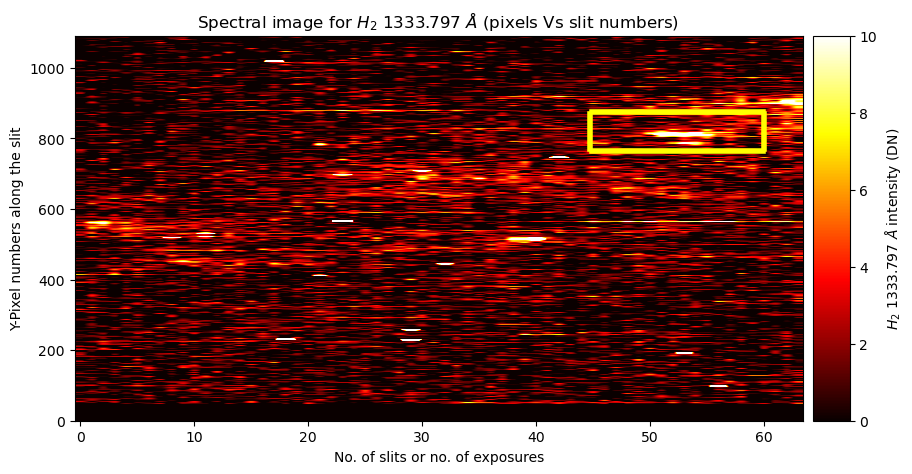

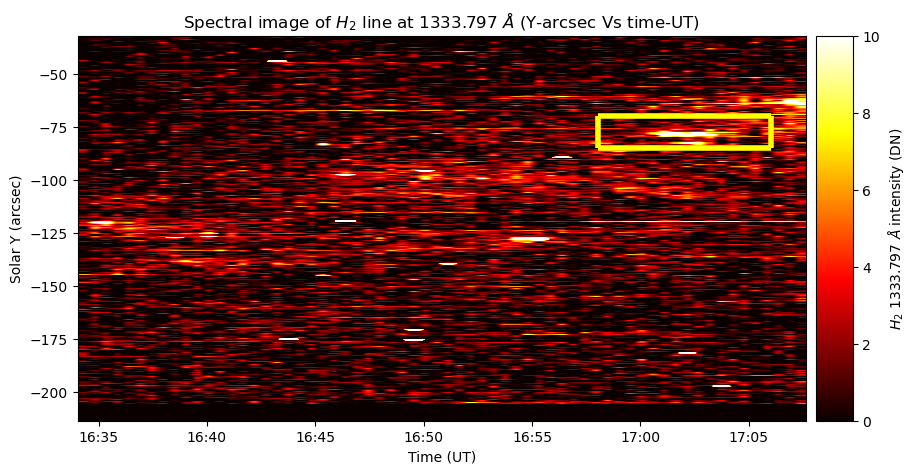

In [27]:
plt.figure(figsize=(10,5))
ax = plt.gca()
im = plt.imshow(win1_c2_sp_data[:,:,h2_1333797_index].T, vmin=0, vmax=10, cmap='hot', aspect='auto') # all time, all Y , at 1 wavelength i.e. H2 1333.797
plt.title("Spectral image for $H_2$ 1333.797 $\AA$ (pixels Vs slit numbers) ")
plt.xlabel('No. of slits or no. of exposures')
plt.ylabel('Y-Pixel numbers along the slit')
# overplot a boxed region to highlight H2 emission
plt.axhline(y=765, xmin=0.71, xmax=0.945, color='yellow', linewidth=4)
plt.axhline(y=875, xmin=0.71, xmax=0.945, color='yellow', linewidth=4)
plt.axvline(x=44.8, ymin=0.705, ymax=0.796, color='yellow', linewidth=4)
plt.axvline(x=60, ymin=0.705, ymax=0.796, color='yellow', linewidth=4)
# colorbar
#plt.clim(0,10) # colourbar limits
# adjust colobar size and location
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im, cax=cax, label = '$H_2$ 1333.797 $\AA$ intensity (DN)')
plt.show()


fig, ax1 = plt.subplots(figsize=(10,5))
im=ax1.imshow(win1_c2_sp_data[:,:, h2_1333797_index].T, vmin=0, vmax=10, aspect="auto", cmap='hot', extent=[times_num[0], times_num[-1], Y_arcsec[0], Y_arcsec[-1]])
ax1.xaxis_date()
date_format = dates.DateFormatter('%H:%M')
ax1.xaxis.set_major_formatter(date_format)
ax1.set_xlabel("Time (UT)")
ax1.set_ylabel("Solar Y (arcsec)")
ax1.set_title("Spectral image of $H_2$ line at 1333.797 $\AA$ (Y-arcsec Vs time-UT)")
# overplot a boxed region to highlight H2 emission
ax1.vlines(x=times_num[45], ymin=-85,ymax= -70,color = 'yellow', linewidth=4)
ax1.vlines(x=times_num[60], ymin=-85, ymax=-70, color = 'yellow', linewidth=4)
ax1.hlines(y=-85, xmin=times_num[45], xmax=times_num[60], color='yellow', linewidth=4)
ax1.hlines(y=-70, xmin=times_num[45], xmax=times_num[60], color='yellow', linewidth=4)
# colourbar
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.

divider = make_axes_locatable(ax1)
cax1 = divider.append_axes("right", size="5%", pad=0.1)
#plt.clim(0,10) # colourbar limits

cbar = fig.colorbar(im, ax=ax1, cax=cax1, label = '$H_2$ 1333.797 $\AA$ intensity (DN)') #, ticks=[0,2,4,6,8,10]
plt.show()



## **Creating subplots in 1 row with 2 columns** ## 

<>:6: SyntaxWarning: invalid escape sequence '\A'
<>:19: SyntaxWarning: invalid escape sequence '\A'
<>:29: SyntaxWarning: invalid escape sequence '\A'
<>:42: SyntaxWarning: invalid escape sequence '\A'
<>:6: SyntaxWarning: invalid escape sequence '\A'
<>:19: SyntaxWarning: invalid escape sequence '\A'
<>:29: SyntaxWarning: invalid escape sequence '\A'
<>:42: SyntaxWarning: invalid escape sequence '\A'
/var/folders/g9/w6z321fx25s_jyvjvcjz53480000gn/T/ipykernel_20473/246728379.py:6: SyntaxWarning: invalid escape sequence '\A'
  axs[0].set_title("Spectral image of $H_2$ line at 1333.797 $\AA$ (Y-pixels Vs slit numbers)")
/var/folders/g9/w6z321fx25s_jyvjvcjz53480000gn/T/ipykernel_20473/246728379.py:19: SyntaxWarning: invalid escape sequence '\A'
  cbar = fig.colorbar(im0, ax=axs[0], cax=cax0, label = '$H_2$ 1333.797 $\AA$ intensity (DN)') #, ticks=[0,2,4,6,8,10]
/var/folders/g9/w6z321fx25s_jyvjvcjz53480000gn/T/ipykernel_20473/246728379.py:29: SyntaxWarning: invalid escape sequence '\A'
  

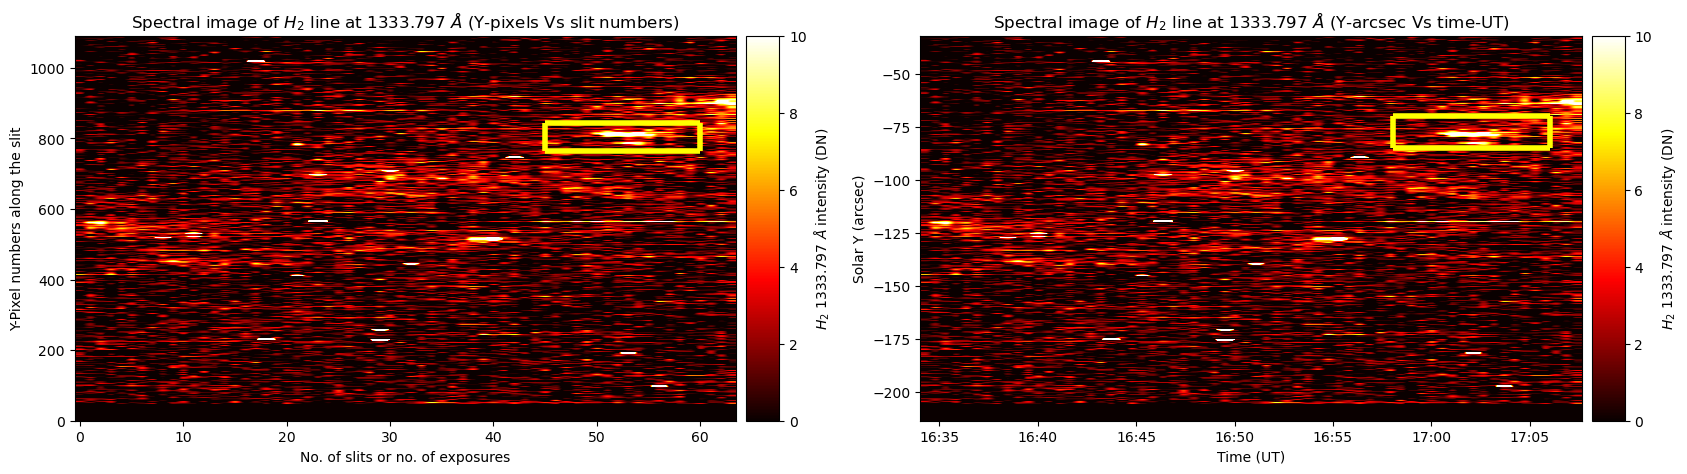

In [28]:
## plot spectral image - Y-pix Vs No. of slits
fig, axs = plt.subplots(1,2,figsize=(20,5))
im0 = axs[0].imshow(win1_c2_sp_data[:,:,h2_1333797_index].T, vmin=0, vmax=10, cmap='hot', aspect='auto')
axs[0].set_xlabel("No. of slits or no. of exposures")
axs[0].set_ylabel("Y-Pixel numbers along the slit")
axs[0].set_title("Spectral image of $H_2$ line at 1333.797 $\AA$ (Y-pixels Vs slit numbers)")
# overplot a boxed region to highlight H2 emission
axs[0].vlines(x=45, ymin=765, ymax=845, color = 'yellow', linewidth=4)
axs[0].vlines(x=60, ymin=765, ymax=845, color = 'yellow', linewidth=4)
axs[0].hlines(y=765, xmin=45, xmax=60, color='yellow', linewidth=4)
axs[0].hlines(y=845, xmin=45, xmax=60, color='yellow', linewidth=4)
# colorbar
#plt.clim(0,10) # colourbar limits
# adjust colobar size and location
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(axs[0])
cax0 = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(im0, ax=axs[0], cax=cax0, label = '$H_2$ 1333.797 $\AA$ intensity (DN)') #, ticks=[0,2,4,6,8,10]


## plot spectral image - Y-arcsec Vs Time-UT
im1 = axs[1].imshow(win1_c2_sp_data[:,:, h2_1333797_index].T, vmin=0, vmax=10, aspect="auto", cmap='hot', extent=[times_num[0], times_num[-1], Y_arcsec[0], Y_arcsec[-1]])
axs[1].xaxis_date()
date_format = dates.DateFormatter('%H:%M')
axs[1].xaxis.set_major_formatter(date_format)
axs[1].set_xlabel("Time (UT)")
axs[1].set_ylabel("Solar Y (arcsec)")
axs[1].set_title("Spectral image of $H_2$ line at 1333.797 $\AA$ (Y-arcsec Vs time-UT)")
#axs[1].set_clim(vmin = 0, vmax = 10)
# overplot a boxed region to highlight H2 emission
axs[1].vlines(x=times_num[45], ymin=-85,ymax= -70,color = 'yellow', linewidth=4)
axs[1].vlines(x=times_num[60], ymin=-85, ymax=-70, color = 'yellow', linewidth=4)
axs[1].hlines(y=-85, xmin=times_num[45], xmax=times_num[60], color='yellow', linewidth=4)
axs[1].hlines(y=-70, xmin=times_num[45], xmax=times_num[60], color='yellow', linewidth=4)
# colourbar
# adjust colobar size and location
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(axs[1])
cax1 = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(im1, ax=axs[1], cax=cax1, label = '$H_2$ 1333.797 $\AA$ intensity (DN)') #, ticks=[0,2,4,6,8,10]
#plt.clim(0,10) # colourbar limits

plt.show()


## **Zoomed-in the region where $H_2$ is present** ##

<>:6: SyntaxWarning: invalid escape sequence '\A'
<>:14: SyntaxWarning: invalid escape sequence '\A'
<>:23: SyntaxWarning: invalid escape sequence '\A'
<>:30: SyntaxWarning: invalid escape sequence '\A'
<>:6: SyntaxWarning: invalid escape sequence '\A'
<>:14: SyntaxWarning: invalid escape sequence '\A'
<>:23: SyntaxWarning: invalid escape sequence '\A'
<>:30: SyntaxWarning: invalid escape sequence '\A'
/var/folders/g9/w6z321fx25s_jyvjvcjz53480000gn/T/ipykernel_20473/2833083098.py:6: SyntaxWarning: invalid escape sequence '\A'
  axs[0].set_title("Spectral image of $H_2$ line at 1333.797 $\AA$ (Y-pixels Vs slit numbers)")
/var/folders/g9/w6z321fx25s_jyvjvcjz53480000gn/T/ipykernel_20473/2833083098.py:14: SyntaxWarning: invalid escape sequence '\A'
  cbar = fig.colorbar(im0, ax=axs[0], cax=cax0, label = '$H_2$ 1333.797 $\AA$ intensity (DN)') #, ticks=[0,2,4,6,8,10]
/var/folders/g9/w6z321fx25s_jyvjvcjz53480000gn/T/ipykernel_20473/2833083098.py:23: SyntaxWarning: invalid escape sequence '\A'

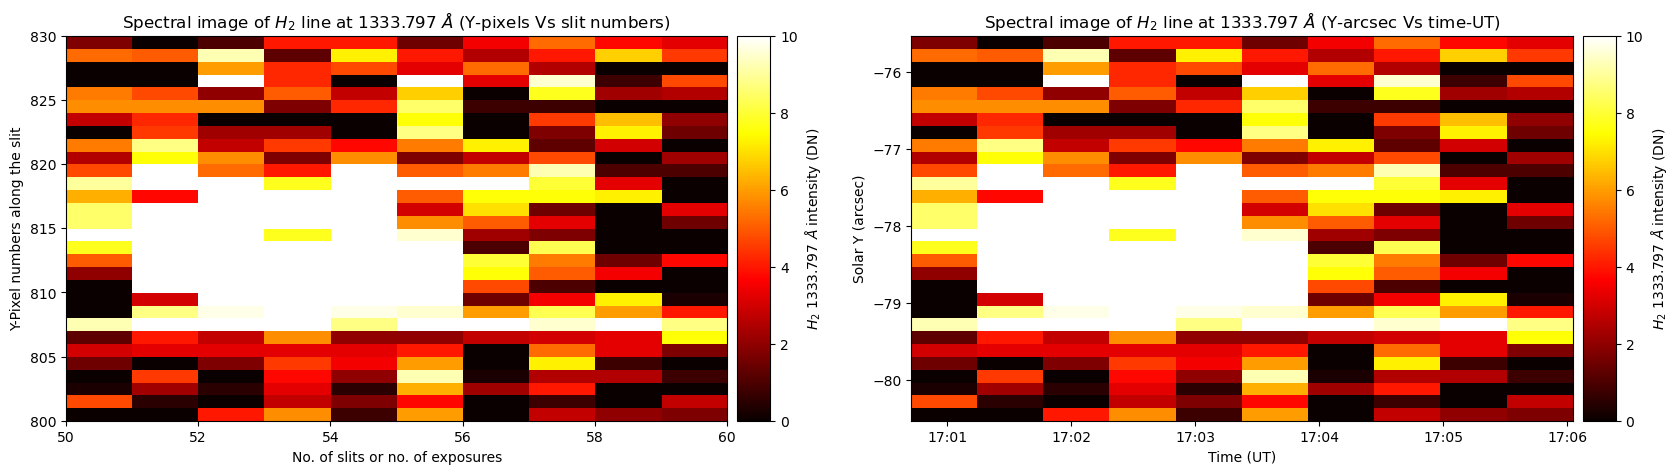

In [29]:
# plot spectral image - Y-pix Vs No. of slits
fig, axs = plt.subplots(1,2,figsize=(20,5))
im0 = axs[0].imshow(win1_c2_sp_data[50:60,800:830,h2_1333797_index].T, vmin=0, vmax=10, cmap='hot', aspect='auto', extent = [50,60,800,830])
axs[0].set_xlabel("No. of slits or no. of exposures")
axs[0].set_ylabel("Y-Pixel numbers along the slit")
axs[0].set_title("Spectral image of $H_2$ line at 1333.797 $\AA$ (Y-pixels Vs slit numbers)")
# colorbar
#plt.clim(0,10) # colourbar limits
# adjust colobar size and location
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(axs[0])
cax0 = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(im0, ax=axs[0], cax=cax0, label = '$H_2$ 1333.797 $\AA$ intensity (DN)') #, ticks=[0,2,4,6,8,10]

## plot spectral image - Y-arcsec Vs Time-UT
im1 = axs[1].imshow(win1_c2_sp_data[50:60,800:830,h2_1333797_index].T, vmin=0, vmax=10, aspect="auto", cmap='hot', extent=[times_num[50], times_num[60], Y_arcsec[800], Y_arcsec[830]])
axs[1].xaxis_date()
date_format = dates.DateFormatter('%H:%M')
axs[1].xaxis.set_major_formatter(date_format)
axs[1].set_xlabel("Time (UT)")
axs[1].set_ylabel("Solar Y (arcsec)")
axs[1].set_title("Spectral image of $H_2$ line at 1333.797 $\AA$ (Y-arcsec Vs time-UT)")
#colourbar
# adjust colobar size and location
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(axs[1])
cax1 = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(im1, ax=axs[1], cax=cax1, label = '$H_2$ 1333.797 $\AA$ intensity (DN)') #, ticks=[0,2,4,6,8,10]
#plt.clim(0,10) # colourbar limits
plt.show()


## **Plot detector images** ## 
### **$H_2$ is present for X = slit numbers 51-55 and Y = 808-820 pixels or 79-77 arcsec** ###

In [30]:
win1_c2_sp_data[51].shape
# 1092 = Y-pixels
# 2058 = size of wavelength array

(1092, 2058)

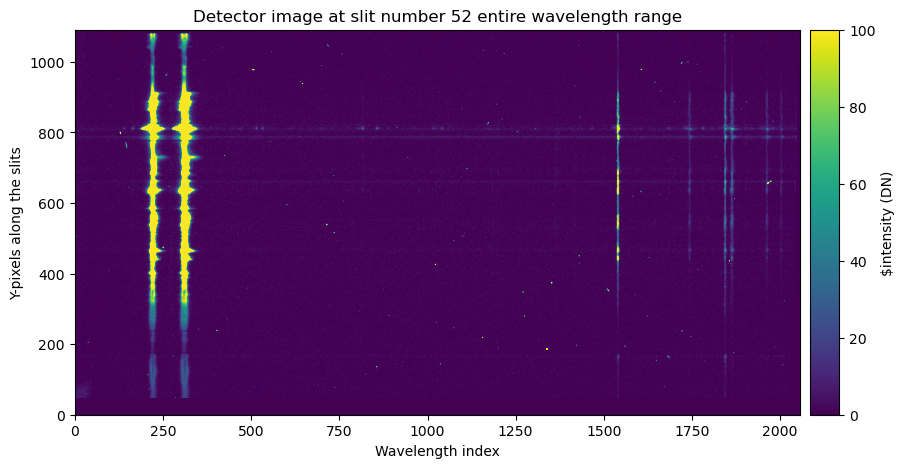

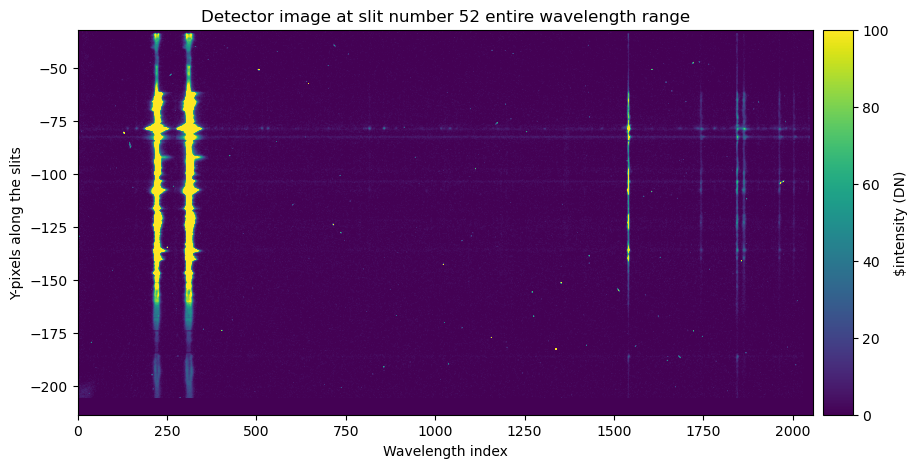

In [31]:
plt.figure(figsize=(10,5))
ax = plt.gca()
im0 = plt.imshow(win1_c2_sp_data[52], vmin=0, vmax=100)
plt.title("Detector image at slit number 52 entire wavelength range")
plt.ylabel("Y-pixels along the slits")
plt.xlabel("Wavelength index")
#plt.clim(0,100) # colourbar limits
#plt.colorbar(label = 'intensity (DN)')
# colorbar
#plt.clim(0,10) # colourbar limits
# adjust colobar size and location
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="4%", pad=0.1)
plt.colorbar(im0, cax=cax, label = '$intensity (DN)')

plt.show()

fig, ax1 = plt.subplots(figsize=(10,5))
im1 = plt.imshow(win1_c2_sp_data[52], vmin=0, vmax=100, extent = [0, 2057, Y_arcsec[0], Y_arcsec[-1]],aspect="auto")
plt.title("Detector image at slit number 52 entire wavelength range")
plt.ylabel("Y-pixels along the slits")
plt.xlabel("Wavelength index")
plt.clim(0,100) # colourbar limits
# colourbar
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax1)
cax1 = divider.append_axes("right", size="4%", pad=0.1)
#plt.clim(0,10) # colourbar limits

cbar = fig.colorbar(im1, ax=ax1, cax=cax1, label = '$intensity (DN)') #, ticks=[0,2,4,6,8,10]

plt.show()

## **Zoom-in over the $H_2$ wavelength region in detector image** ##

In [32]:
win1_c2_sp_data[52].shape

# first dimension = no. of Y-pix
# second dimension = no. of slits

(1092, 2058)

<>:5: SyntaxWarning: invalid escape sequence '\A'
<>:20: SyntaxWarning: invalid escape sequence '\A'
<>:5: SyntaxWarning: invalid escape sequence '\A'
<>:20: SyntaxWarning: invalid escape sequence '\A'
/var/folders/g9/w6z321fx25s_jyvjvcjz53480000gn/T/ipykernel_20473/3427464069.py:5: SyntaxWarning: invalid escape sequence '\A'
  plt.title("Detector image at slit number 52 two $H_2$ lines at 1333.481 and 1333.797 $\AA$")
/var/folders/g9/w6z321fx25s_jyvjvcjz53480000gn/T/ipykernel_20473/3427464069.py:20: SyntaxWarning: invalid escape sequence '\A'
  plt.title("Detector image at slit number 52 two $H_2$ lines at 1333.481 and 1333.797 $\AA$")


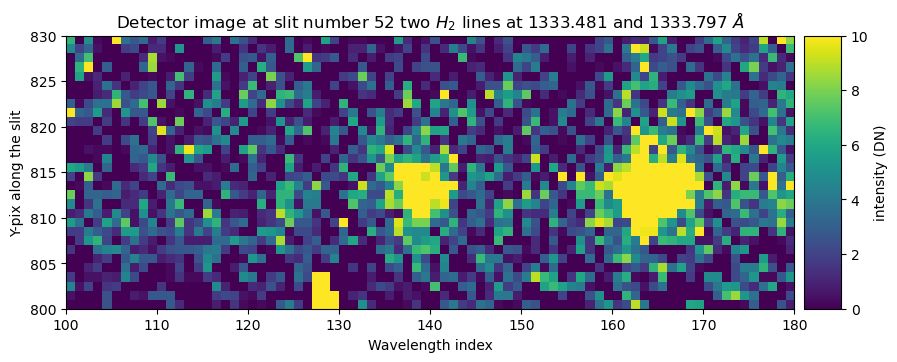

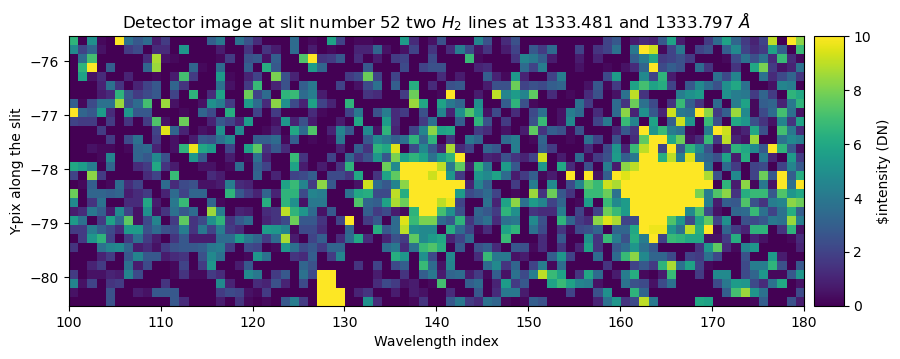

In [33]:
# Here Y-pix = 800-830 and X-wavelength index = 100-180
plt.figure(figsize=(10,5))
ax = plt.gca()
im = plt.imshow(win1_c2_sp_data[52][800:830,100:180], vmin=0, vmax=10, extent = [100,180,800,830])
plt.title("Detector image at slit number 52 two $H_2$ lines at 1333.481 and 1333.797 $\AA$")
plt.ylabel("Y-pix along the slit")
plt.xlabel("Wavelength index")
plt.clim(0,10) # colourbar limits
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im, cax=cax, label = 'intensity (DN)')
plt.show()


# Here Y-pix = 800-830 and X-wavelength index = 100-180
fig, ax1 = plt.subplots(figsize=(10,3.5))
im1 = plt.imshow(win1_c2_sp_data[52][800:830,100:180], vmin=0, vmax=10, extent=[100,180, Y_arcsec[800], Y_arcsec[830]], aspect="auto")
plt.title("Detector image at slit number 52 two $H_2$ lines at 1333.481 and 1333.797 $\AA$")
plt.ylabel("Y-pix along the slit")
plt.xlabel("Wavelength index")
# colourbar
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax1)
cax1 = divider.append_axes("right", size="4%", pad=0.1)
#plt.clim(0,10) # colourbar limits

cbar = fig.colorbar(im1, ax=ax1, cax=cax1, label = '$intensity (DN)') #, ticks=[0,2,4,6,8,10]

plt.show()

## **Plot $H_2$ spectral images for win 1 - 1333 - 1357 Å** ##

In [34]:
win1_h2_wave = np.array([1333.48, 1333.8, 1334.48, 1334.5, 1335.55, 1335.57, 1335.58, 1337.47, 1338.57, 1340.79, 1342.26, 1342.89, 1345.05, 1345.09, 1346.91, 1352.5, 1356.48, 1356.85])

# create a list to store the H2 wavelength
win1_h2_wave_list = []

# create a list to store index for each H2 wavelength
win1_h2_index = []

# this is for loop for identifying the indexes for H2 wavelength
print("H\N{SUBSCRIPT TWO} spectral lines between 1333 - 1357 \u00c5")
print(" ")
for i in win1_h2_wave:
    win1_h2_wave_list.append(i) # store the H2 wavelength in this array
    #print("Value to which the nearest element is to be found:", i)
    difference_array1 = np.absolute(win1_c2_wavelength - i)
    index1 = difference_array1.argmin()
    #print("Nearest element to the given value is:", win1_c2_wavelength[index1])
    #print("Nearest element+1 to the given value is:", win1_c2_wavelength[index1+1])
    #print("Index of nearest value is:", index1)
    #print(" ")
    win1_h2_index.append(index1)
    H2_index1 = np.argmin(np.abs(win1_c2_wavelength -  i))
    
print('H\N{SUBSCRIPT TWO} wavelengths in (\u00c5) = ', win1_h2_wave)
print(" ")
print('H\N{SUBSCRIPT TWO} wavelength index = ', win1_h2_index)


H₂ spectral lines between 1333 - 1357 Å
 
H₂ wavelengths in (Å) =  [1333.48 1333.8  1334.48 1334.5  1335.55 1335.57 1335.58 1337.47 1338.57
 1340.79 1342.26 1342.89 1345.05 1345.09 1346.91 1352.5  1356.48 1356.85]
 
H₂ wavelength index =  [np.int64(138), np.int64(163), np.int64(215), np.int64(217), np.int64(298), np.int64(299), np.int64(300), np.int64(446), np.int64(531), np.int64(702), np.int64(815), np.int64(863), np.int64(1030), np.int64(1033), np.int64(1173), np.int64(1604), np.int64(1910), np.int64(1939)]


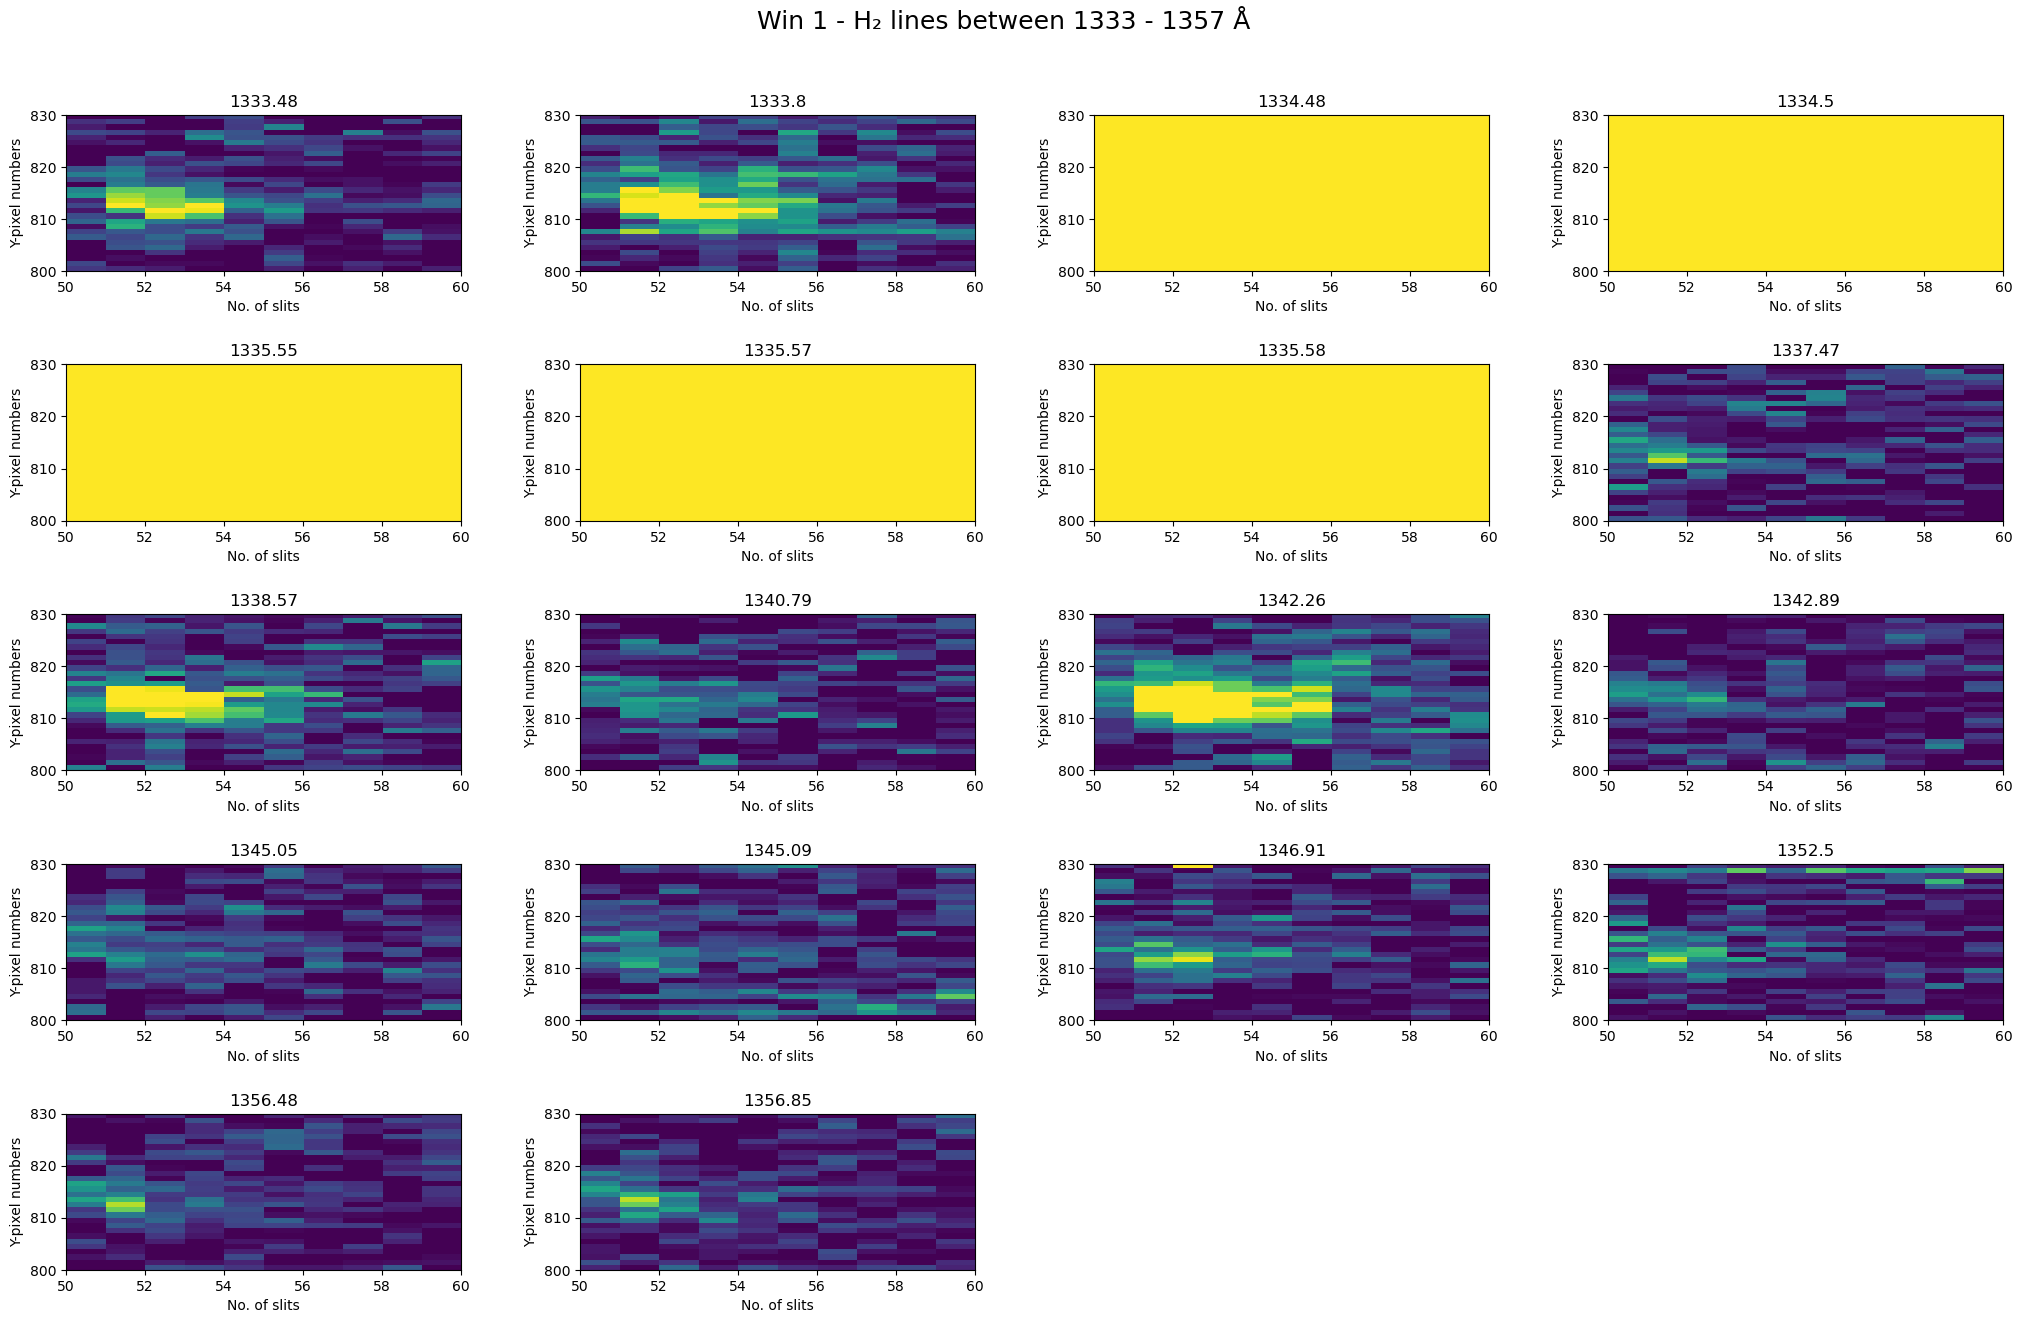

In [35]:
win1_h2_index_arr = np.array(win1_h2_index)
win1_h2_wave_arr = np.array(win1_h2_wave)

plt.figure(figsize=(25, 15))
plt.subplots_adjust(hspace=0.6, wspace=0.3)
plt.suptitle("Win 1 - H\N{SUBSCRIPT TWO} lines between 1333 - 1357 \u00c5", fontsize=18, y=0.95)

# set number of columns 
ncols = 4

# calculate number of rows
nrows = len(win1_h2_wave) // ncols + (len(win1_h2_wave) % ncols > 0)

# loop through the length of tickers and keep track of index
for n, win1_h2_wave in enumerate(win1_h2_wave):
    # add a new subplot iteratively using nrows and cols
    ax = plt.subplot(nrows, ncols, n + 1)

    # filter df and plot ticker on the new subplot axis
    #df[df["h2_wave1"] == h2_wave1].plot(ax=ax)
    ax.imshow(sp[1].data[50:60,800:830,  win1_h2_index_arr[n]].T, vmin=0, vmax=20, aspect="auto", extent = [50,60,800,830])


    # chart formatting
    #ax.set_title(h2_wave1.upper())
    #ax.get_legend().remove()
    ax.set_title(win1_h2_wave_arr[n])
    ax.set_xlabel('No. of slits')
    ax.set_ylabel('Y-pixel numbers')

## **Plot $H_2$ spectral images for win 2 - 1393-1402 Å** ##

In [36]:
win2_h2_wave = np.array([1393.45, 1393.72, 1393.73, 1393.9, 1395.2, 1396.22, 1397.42, 1398.95, 1400.61, 1402.65, 1403.38, 1404.75])

# create a list to store the H2 wavelength
win2_h2_wave_list = []

# create a list to store index for each H2 wavelength
win2_h2_index = []

# this is for loop for identifying the indexes for H2 wavelength
print('H\N{SUBSCRIPT TWO} spectral lines between 1393-1402 \u00c5')
print(" ")
for ii in win2_h2_wave:
    win2_h2_wave_list.append(ii) # store the H2 wavelength in this array
    #print("Value to which the nearest element is to be found:", ii)
    difference_array2 = np.absolute(win2_si4_wavelength - ii)
    index2 = difference_array2.argmin()
    #print("Nearest element to the given value is:", win2_si4_wavelength[index2])
    #print("Nearest element+1 to the given value is:", win2_si4_wavelength[index2+1])
    #print("Index of nearest value is:", index1)
    #print(" ")
    win2_h2_index.append(index2)
    H2_index2 = np.argmin(np.abs(win2_si4_wavelength -  ii))
    
print('H\N{SUBSCRIPT TWO} wavelengths in (\u00c5) = ', win2_h2_wave)
print(" ")
print('H\N{SUBSCRIPT TWO} wavelength index = ', win2_h2_index)


H₂ spectral lines between 1393-1402 Å
 
H₂ wavelengths in (Å) =  [1393.45 1393.72 1393.73 1393.9  1395.2  1396.22 1397.42 1398.95 1400.61
 1402.65 1403.38 1404.75]
 
H₂ wavelength index =  [np.int64(1003), np.int64(1024), np.int64(1025), np.int64(1039), np.int64(1141), np.int64(1221), np.int64(1315), np.int64(1436), np.int64(1566), np.int64(1726), np.int64(1784), np.int64(1892)]


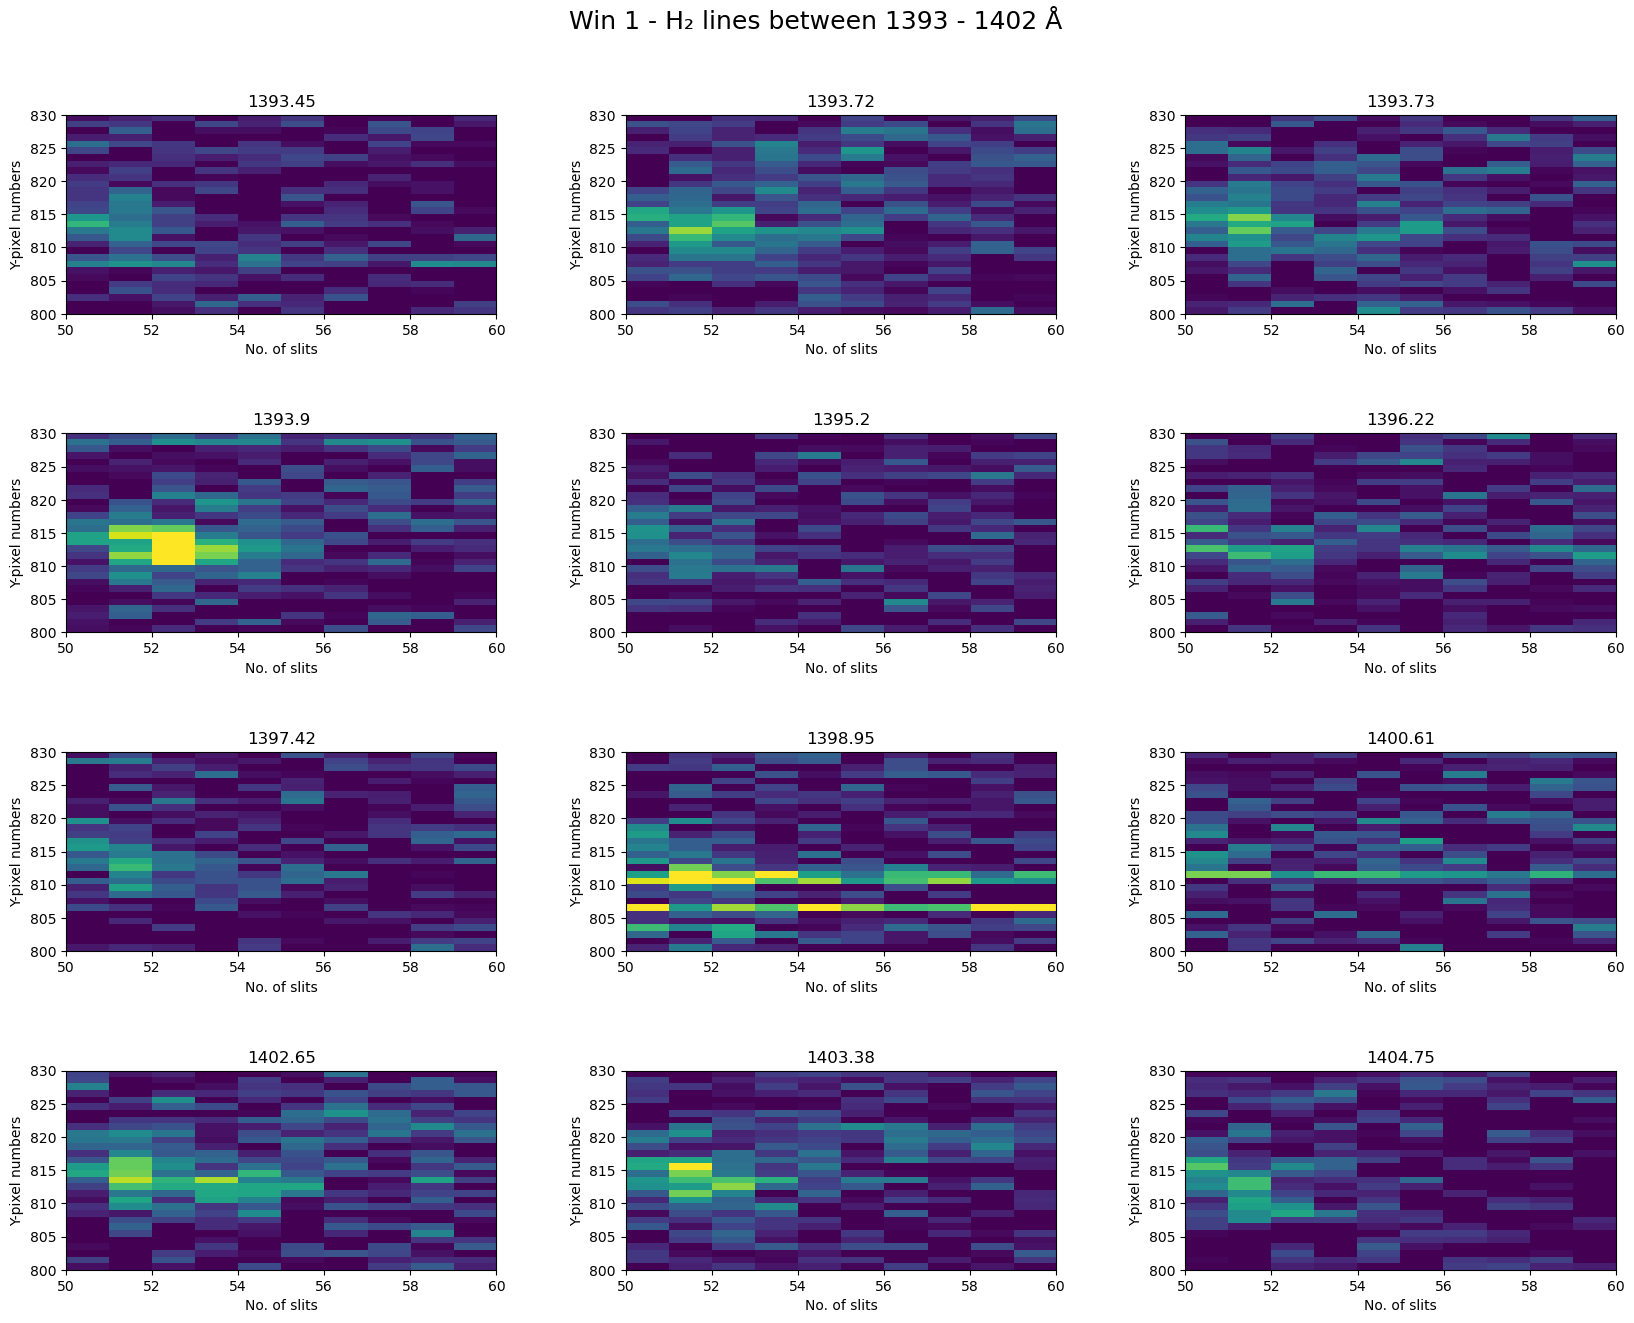

In [37]:
win2_h2_index_arr = np.array(win2_h2_index)
win2_h2_wave_arr = np.array(win2_h2_wave)

plt.figure(figsize=(20, 15))
plt.subplots_adjust(hspace=0.6, wspace=0.3)
plt.suptitle("Win 1 - H\N{SUBSCRIPT TWO} lines between 1393 - 1402 \u00c5", fontsize=18, y=0.95)

# set number of columns (use 3 to demonstrate the change)
ncols = 3
# calculate number of rows
nrows = len(win2_h2_wave) // ncols + (len(win2_h2_wave) % ncols > 0)

# loop through the length of tickers and keep track of index
for n, win2_h2_wave in enumerate(win2_h2_wave):
    # add a new subplot iteratively using nrows and cols
    ax = plt.subplot(nrows, ncols, n + 1)

    # filter df and plot ticker on the new subplot axis
    #df[df["h2_wave1"] == h2_wave1].plot(ax=ax)
    ax.imshow(sp[1].data[50:60,800:830,  win2_h2_index_arr[n]].T, vmin=0, vmax=20, aspect="auto", extent = [50,60,800,830])


    # chart formatting
    #ax.set_title(h2_wave1.upper())
    #ax.get_legend().remove()
    ax.set_title(win2_h2_wave_arr[n])
    ax.set_xlabel('No. of slits')
    ax.set_ylabel('Y-pixel numbers')



## **Get the time for slits where $H_2$ was observed** ##

In [38]:
# get the time for slit 52
print('time for slit 51-56 = ',times[51:56])


time for slit 51-56 =  ['2014-02-11T17:01:14.711' '2014-02-11T17:01:46.711'
 '2014-02-11T17:02:18.711' '2014-02-11T17:02:50.711'
 '2014-02-11T17:03:22.711']


## **Displaying spectrum at 1-slit position at 1 pixel for two $H_2$ lines at 1333.481 and 1333.797 Å** ##

<>:5: SyntaxWarning: invalid escape sequence '\A'
<>:15: SyntaxWarning: invalid escape sequence '\A'
<>:23: SyntaxWarning: invalid escape sequence '\A'
<>:5: SyntaxWarning: invalid escape sequence '\A'
<>:15: SyntaxWarning: invalid escape sequence '\A'
<>:23: SyntaxWarning: invalid escape sequence '\A'
/var/folders/g9/w6z321fx25s_jyvjvcjz53480000gn/T/ipykernel_20473/2158427821.py:5: SyntaxWarning: invalid escape sequence '\A'
  plt.title("Spectral image for $H_2$ 1333.797 $\AA$ (pixels Vs slit numbers) ")
/var/folders/g9/w6z321fx25s_jyvjvcjz53480000gn/T/ipykernel_20473/2158427821.py:15: SyntaxWarning: invalid escape sequence '\A'
  plt.colorbar(im, cax=cax, label = '$H_2$ 1333.797 $\AA$ intensity (DN)')
/var/folders/g9/w6z321fx25s_jyvjvcjz53480000gn/T/ipykernel_20473/2158427821.py:23: SyntaxWarning: invalid escape sequence '\A'
  plt.title('$H_2$ 1333.481 and 133.797 $\AA$ spectrum at slit 52')


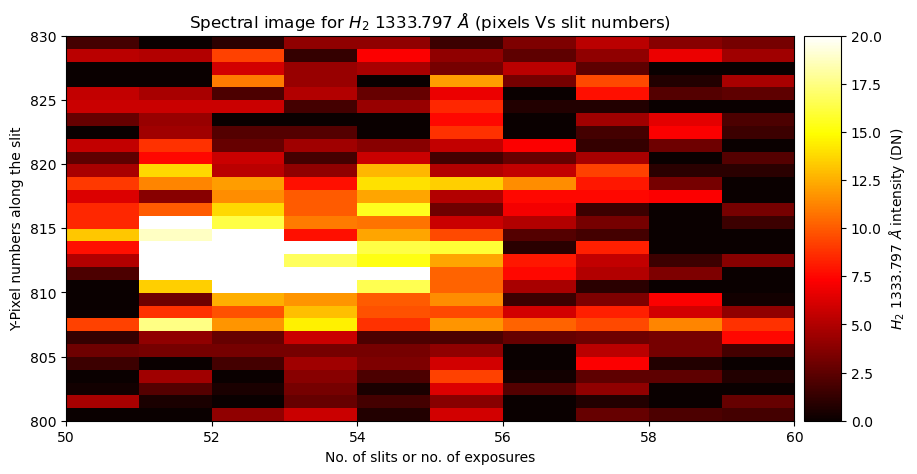

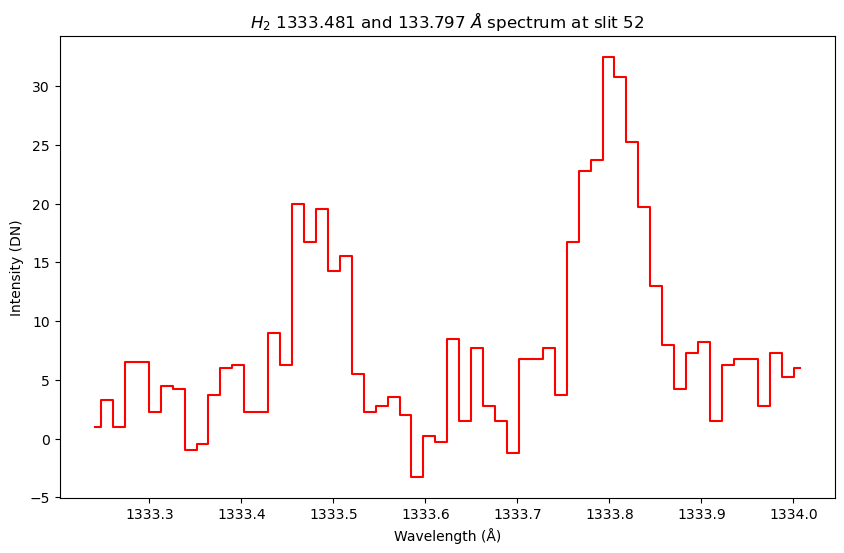

In [39]:
# Display the spectral image at H2 1333.797 Angstrom
plt.figure(figsize=(10,5))
ax = plt.gca()
im = plt.imshow(win1_c2_sp_data[50:60,800:830,h2_1333797_index].T, vmin=0, vmax=20, cmap='hot', aspect='auto', extent = [50,60,800,830]) # all time, all Y , at 1 wavelength i.e. H2 1333.797
plt.title("Spectral image for $H_2$ 1333.797 $\AA$ (pixels Vs slit numbers) ")
plt.xlabel('No. of slits or no. of exposures')
plt.ylabel('Y-Pixel numbers along the slit')
# colorbar
#plt.clim(0,10) # colourbar limits
# adjust colobar size and location
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im, cax=cax, label = '$H_2$ 1333.797 $\AA$ intensity (DN)')
plt.show()


# plot spectrum for H2 lines at 1333.481 and 1333.797 Å at signle slit position
plt.plot(win1_c2_wavelength[120:180], win1_c2_sp_data[52,812,120:180], color = 'r', ds ='steps-mid')
plt.xlabel('Wavelength (Å)')
plt.ylabel('Intensity (DN)')
plt.title('$H_2$ 1333.481 and 133.797 $\AA$ spectrum at slit 52')
plt.show()

## **Displaying spectrum at 1-slit averaged over Y-pixels for two $H_2$ lines at 1333.481 & 1333.797 Å** ##

Win1 H2 wavelengths =  [1333.48 1333.8  1334.48 1334.5  1335.55 1335.57 1335.58 1337.47 1338.57
 1340.79 1342.26 1342.89 1345.05 1345.09 1346.91 1352.5  1356.48 1356.85]
Win1 H2 wavelength index =  [ 138  163  215  217  298  299  300  446  531  702  815  863 1030 1033
 1173 1604 1910 1939]

h2_1333797_wavelenth =  (43,)
h2_1333797_avg_sp_range =  (8, 43)

h2_1333797_avg_sp =  (43,)



<>:39: SyntaxWarning: invalid escape sequence '\A'
<>:39: SyntaxWarning: invalid escape sequence '\A'
/var/folders/g9/w6z321fx25s_jyvjvcjz53480000gn/T/ipykernel_20473/4063970192.py:39: SyntaxWarning: invalid escape sequence '\A'
  plt.xlabel("Wavelength ($\AA$)")
/var/folders/g9/w6z321fx25s_jyvjvcjz53480000gn/T/ipykernel_20473/4063970192.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


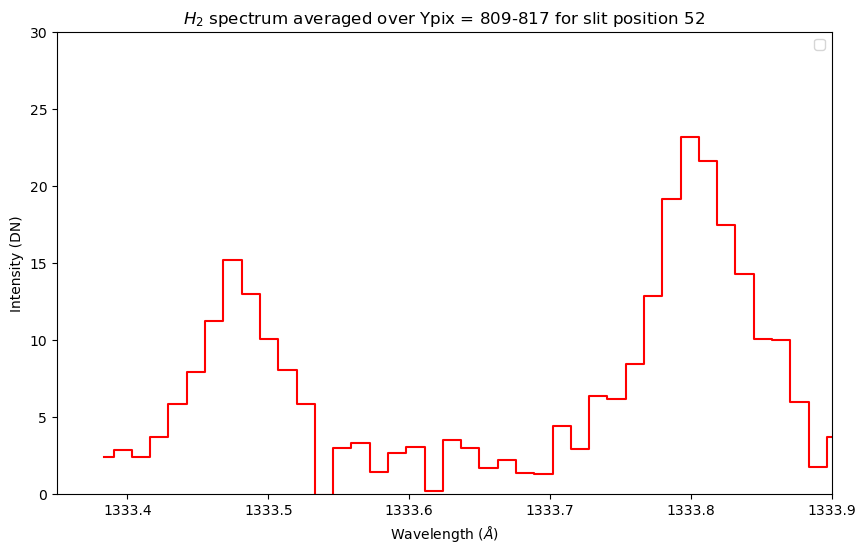

In [40]:
# Display the spectral image at H2 averaged over the 1333.7-1333.797 Angstrom

# find the wavelength index for H2 line

win1_h2_wave_array = np.array([1333.48, 1333.8, 1334.48, 1334.5, 1335.55, 1335.57, 1335.58, 1337.47, 1338.57, 1340.79, 1342.26, 1342.89, 1345.05, 1345.09, 1346.91, 1352.5, 1356.48, 1356.85])
win1_h2_index_array = np.array([138, 163, 215, 217, 298, 299, 300, 446, 531, 702, 815, 863, 1030, 1033, 1173, 1604, 1910, 1939])

print('Win1 H2 wavelengths = ', win1_h2_wave_array)
print('Win1 H2 wavelength index = ', win1_h2_index_array)
print('')
# print(win1_c2_wavelength[158:171]) 
# [1333.73412017 1333.74710017 1333.76008017 1333.77306017 1333.78604017
# 1333.79902017 1333.81200017 1333.82498017 1333.83796017 1333.85094017
# 1333.86392017 1333.87690017 1333.88988017]

# wavelength range for the spectra
h2_1333797_lambda_min_index = 131 #155 # 158 
h2_1333797_lambda_max_index = 174 # 171
h2_1333797_wavelenth = win1_c2_wavelength[h2_1333797_lambda_min_index:h2_1333797_lambda_max_index]
print('h2_1333797_wavelenth = ', h2_1333797_wavelenth.shape)

# slit number for the spectra
slit_no = 52

# Y-pix range for the spectra
ypix_min = 809
ypix_max = 817
h2_1333797_avg_sp_range = win1_c2_sp_data[slit_no, ypix_min:ypix_max, h2_1333797_lambda_min_index:h2_1333797_lambda_max_index]
print('h2_1333797_avg_sp_range = ', h2_1333797_avg_sp_range.shape)
print('')
h2_1333797_avg_sp = h2_1333797_avg_sp_range.mean(axis=0) # average over Y-pixels
print('h2_1333797_avg_sp = ', h2_1333797_avg_sp.shape)
print('')
#print(win1_c2_sp_data.shape)

plt.plot(h2_1333797_wavelenth, h2_1333797_avg_sp, color = 'r', ds ='steps-mid')
plt.xlim(1333.35,1333.9)
plt.ylim(0,30)
plt.xlabel("Wavelength ($\AA$)")
plt.ylabel("Intensity (DN)")
plt.ticklabel_format(useOffset=False)
plt.title("$H_2$ spectrum averaged over Ypix = 809-817 for slit position 52")
plt.legend()
plt.show()

## **Create a light curve - averaged over Y-pix and averaged single Wavelength** ## 

(time, Y-pixel, wavelength) (64, 1092, 2058)


<>:24: SyntaxWarning: invalid escape sequence '\A'
<>:24: SyntaxWarning: invalid escape sequence '\A'
/var/folders/g9/w6z321fx25s_jyvjvcjz53480000gn/T/ipykernel_20473/1736448489.py:24: SyntaxWarning: invalid escape sequence '\A'
  axs[0].set_title('Light curve at $H_2$ 1333.797 $\AA$ (averaged over Y-pixels along the slit)')


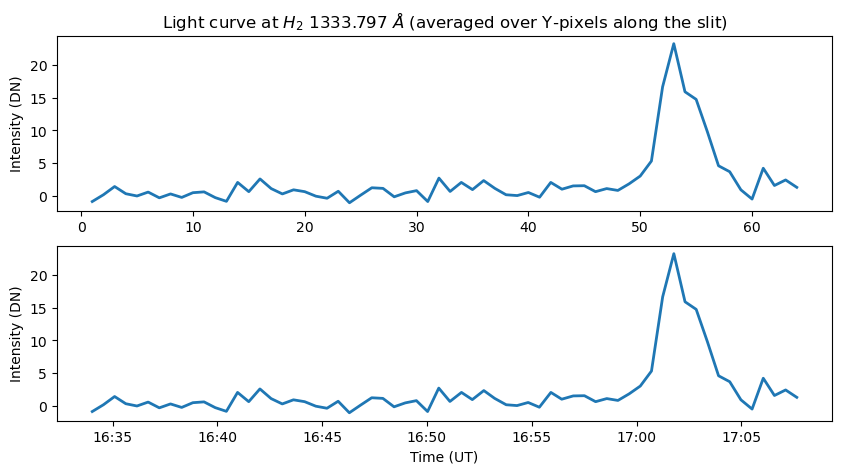

In [41]:
# choose H2 1333.797 a single wavelength 
h2_133797_wavelength = 1333.797
h2_133797_wavelength_index = 163

# Y-pix range for the spectra
ypix_min = 809
ypix_max = 817

print('(time, Y-pixel, wavelength)', win1_c2_sp_data.shape) # '(time, pixel, wavelength)'

# average over the Y-pixels - all slit positions and at signle wavelength value
select_array = win1_c2_sp_data[:, ypix_min:ypix_max, h2_133797_wavelength_index]
h2_1333797_avg_Ypix_1lambda = select_array.mean(axis=1)
#print(h2_1333797_avg_Ypix_1lambda.shape)

# create array of same size as slit number i.e. 1-64 for this observations
# this is used for creating light curve - intensity vs slit numbers
slit_num_array = np.arange(1,65,1)
# print(slit_num_array.shape)

# plot - light curve - intensity vs slit numbers
fig, axs = plt.subplots(2, figsize=(10,5))
axs[0].plot(slit_num_array, h2_1333797_avg_Ypix_1lambda, linewidth=2.0) 
axs[0].set_title('Light curve at $H_2$ 1333.797 $\AA$ (averaged over Y-pixels along the slit)')
#axs[0].set_xlabel('Slit numbers')
axs[0].set_ylabel('Intensity (DN)')

# # plot - light curve - intensity vs Time (UT)
axs[1].plot(times[0:64],h2_1333797_avg_Ypix_1lambda, linewidth=2.0) 
axs[1].set_xlabel('Time (UT)')
axs[1].set_ylabel('Intensity (DN)')
date_format = dates.DateFormatter('%H:%M')
axs[1].xaxis.set_major_formatter(date_format)



## **Create a light curve - averaged over Y-pix and averaged over wavelengths** ## 

<>:40: SyntaxWarning: invalid escape sequence '\A'
<>:40: SyntaxWarning: invalid escape sequence '\A'
/var/folders/g9/w6z321fx25s_jyvjvcjz53480000gn/T/ipykernel_20473/3213157160.py:40: SyntaxWarning: invalid escape sequence '\A'
  axs[0].set_title('Light curve at $H_2$ summed over 1333.7-1333.9 $\AA$ (averaged over Y-pixels along the slit)')


(time, Y-pixel, wavelength) (64, 1092, 2058)

h2_133797_wave_range =  [1333.68220017 1333.69518017 1333.70816017 1333.72114017 1333.73412017
 1333.74710017 1333.76008017 1333.77306017 1333.78604017 1333.79902017
 1333.81200017 1333.82498017 1333.83796017 1333.85094017 1333.86392017
 1333.87690017 1333.88988017 1333.90286017]
win1_c2_sp_data_h2_range =  (64, 1092, 18)
h2_1333797_avg_Ypix_1lambda (64, 18)
h2_1333797_avg_Ypix_total_lambda =  (64,)
(64,)


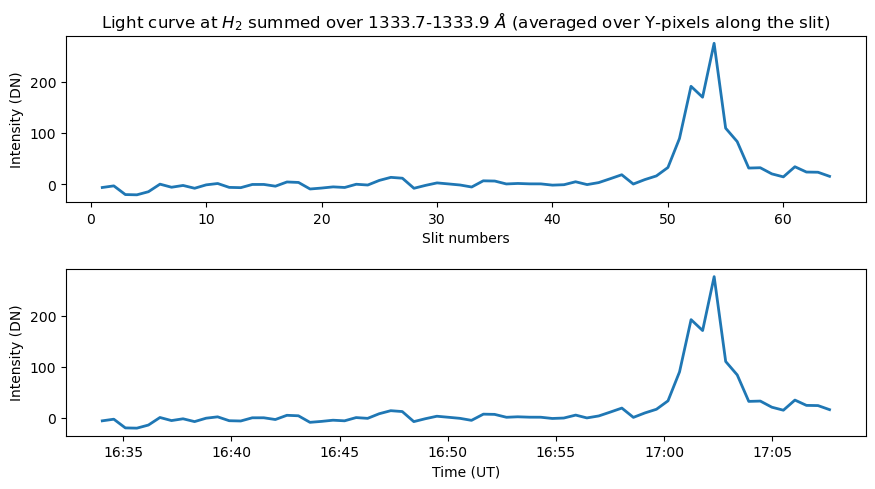

In [42]:
# find the shape of spectral data array
print('(time, Y-pixel, wavelength)', win1_c2_sp_data.shape) # '(time, pixel, wavelength)'
print('')

# choose H2 1333.797 wavelength range as per the spectra - the intensity spread over the range of wavelength

h2_133797_wave_min = 154
h2_133797_wave_max = 172
h2_133797_wave_range = win1_c2_wavelength[h2_133797_wave_min:h2_133797_wave_max]
print('h2_133797_wave_range = ', h2_133797_wave_range)
# 1333.68220017 1333.69518017 1333.70816017 1333.72114017 1333.73412017
# 1333.74710017 1333.76008017 1333.77306017 1333.78604017 1333.79902017
# 1333.81200017 1333.82498017 1333.83796017 1333.85094017 1333.86392017
# 1333.87690017 1333.88988017 1333.90286017

# create a new array and select a wavelength range 
win1_c2_sp_data_h2_range = win1_c2_sp_data[:,:, 154:172]
print('win1_c2_sp_data_h2_range = ', win1_c2_sp_data_h2_range.shape)

# Y-pix range for the spectra
ypix_min = 809
ypix_max = 817

# average over the Y-pixels - all slit positions and all selected wavelengths
select_array = win1_c2_sp_data_h2_range[:, ypix_min:ypix_max, :]
h2_1333797_avg_Ypix_all_lambda = select_array.mean(axis=1)
print('h2_1333797_avg_Ypix_1lambda', h2_1333797_avg_Ypix_all_lambda.shape)

h2_1333797_avg_Ypix_total_lambda = h2_1333797_avg_Ypix_all_lambda.sum(axis=1)
print('h2_1333797_avg_Ypix_total_lambda = ', h2_1333797_avg_Ypix_total_lambda.shape)

# create array of same size as slit number i.e. 1-64 for this observations
# this is used for creating light curve - intensity vs slit numbers
slit_num_array = np.arange(1,65,1)
print(slit_num_array.shape)

# plot - light curve - intensity vs slit numbers
fig, axs = plt.subplots(2, figsize=(10,5))
axs[0].plot(slit_num_array, h2_1333797_avg_Ypix_total_lambda, linewidth=2.0) 
axs[0].set_title('Light curve at $H_2$ summed over 1333.7-1333.9 $\AA$ (averaged over Y-pixels along the slit)')
axs[0].set_xlabel('Slit numbers')
axs[0].set_ylabel('Intensity (DN)')
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.5, hspace=0.4)

# # plot - light curve - intensity vs Time (UT)
axs[1].plot(times[0:64],h2_1333797_avg_Ypix_total_lambda, linewidth=2.0) 
axs[1].set_xlabel('Time (UT)')
axs[1].set_ylabel('Intensity (DN)')
date_format = dates.DateFormatter('%H:%M')
axs[1].xaxis.set_major_formatter(date_format)



## **Spectral image - total over wavelength** ##

<>:28: SyntaxWarning: invalid escape sequence '\A'
<>:36: SyntaxWarning: invalid escape sequence '\A'
<>:45: SyntaxWarning: invalid escape sequence '\A'
<>:52: SyntaxWarning: invalid escape sequence '\A'
<>:28: SyntaxWarning: invalid escape sequence '\A'
<>:36: SyntaxWarning: invalid escape sequence '\A'
<>:45: SyntaxWarning: invalid escape sequence '\A'
<>:52: SyntaxWarning: invalid escape sequence '\A'
/var/folders/g9/w6z321fx25s_jyvjvcjz53480000gn/T/ipykernel_20473/3834403239.py:28: SyntaxWarning: invalid escape sequence '\A'
  axs[0].set_title("Spectral image of $H_2$ 1333.68-1333.90 $\AA$ (Y-pixels Vs slit numbers)")
/var/folders/g9/w6z321fx25s_jyvjvcjz53480000gn/T/ipykernel_20473/3834403239.py:36: SyntaxWarning: invalid escape sequence '\A'
  cbar = fig.colorbar(im0, ax=axs[0], cax=cax0, label = '$H_2$ 1333.797 $\AA$ intensity (DN)') #, ticks=[0,2,4,6,8,10]
/var/folders/g9/w6z321fx25s_jyvjvcjz53480000gn/T/ipykernel_20473/3834403239.py:45: SyntaxWarning: invalid escape sequence '\

(time, Y-pixel, wavelength) (64, 1092, 2058)

h2_133797_wave_range =  [1333.68220017 1333.69518017 1333.70816017 1333.72114017 1333.73412017
 1333.74710017 1333.76008017 1333.77306017 1333.78604017 1333.79902017
 1333.81200017 1333.82498017 1333.83796017 1333.85094017 1333.86392017
 1333.87690017 1333.88988017 1333.90286017]
win1_c2_sp_data_h2_range =  (64, 1092, 18)
win1_c2_sp_data_total_h2_range =  (64, 1092)


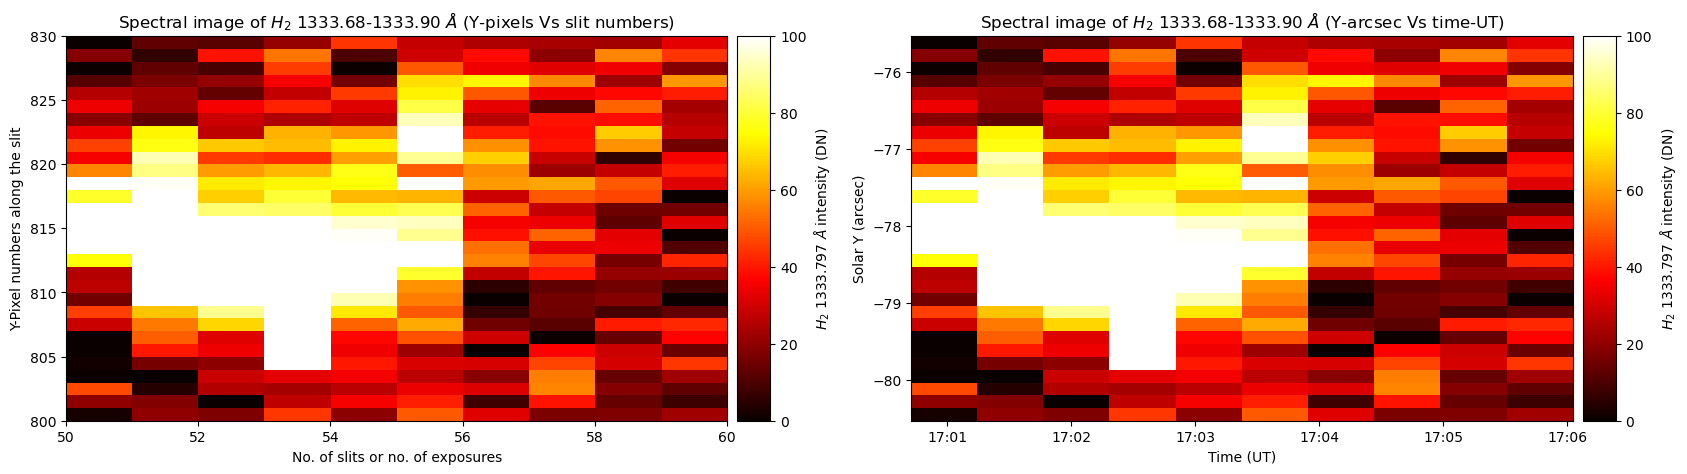

In [43]:
# find the shape of spectral data array
print('(time, Y-pixel, wavelength)', win1_c2_sp_data.shape) # '(time, pixel, wavelength)'
print('')

# choose H2 1333.797 wavelength range as per the spectra - the intensity spread over the range of wavelength

h2_133797_wave_min = 154
h2_133797_wave_max = 172
h2_133797_wave_range = win1_c2_wavelength[h2_133797_wave_min:h2_133797_wave_max]
print('h2_133797_wave_range = ', h2_133797_wave_range)
# 1333.68220017 1333.69518017 1333.70816017 1333.72114017 1333.73412017
# 1333.74710017 1333.76008017 1333.77306017 1333.78604017 1333.79902017
# 1333.81200017 1333.82498017 1333.83796017 1333.85094017 1333.86392017
# 1333.87690017 1333.88988017 1333.90286017

# create a new array and select a wavelength range 
win1_c2_sp_data_h2_range = win1_c2_sp_data[:,:, 154:172]
print('win1_c2_sp_data_h2_range = ', win1_c2_sp_data_h2_range.shape)

win1_c2_sp_data_total_h2_range = win1_c2_sp_data_h2_range.sum(axis=2)
print('win1_c2_sp_data_total_h2_range = ', win1_c2_sp_data_total_h2_range.shape)

# plot spectral image - Y-pix Vs No. of slits
fig, axs = plt.subplots(1,2,figsize=(20,5))
im0 = axs[0].imshow(win1_c2_sp_data_total_h2_range[50:60,800:830].T, vmin=0, vmax=100, cmap='hot', aspect='auto', extent = [50,60,800,830])
axs[0].set_xlabel("No. of slits or no. of exposures")
axs[0].set_ylabel("Y-Pixel numbers along the slit")
axs[0].set_title("Spectral image of $H_2$ 1333.68-1333.90 $\AA$ (Y-pixels Vs slit numbers)")
# colorbar
#plt.clim(0,10) # colourbar limits
# adjust colobar size and location
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(axs[0])
cax0 = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(im0, ax=axs[0], cax=cax0, label = '$H_2$ 1333.797 $\AA$ intensity (DN)') #, ticks=[0,2,4,6,8,10]

## plot spectral image - Y-arcsec Vs Time-UT
im1 = axs[1].imshow(win1_c2_sp_data_total_h2_range[50:60,800:830].T, vmin=0, vmax=100, aspect="auto", cmap='hot', extent=[times_num[50], times_num[60], Y_arcsec[800], Y_arcsec[830]])
axs[1].xaxis_date()
date_format = dates.DateFormatter('%H:%M')
axs[1].xaxis.set_major_formatter(date_format)
axs[1].set_xlabel("Time (UT)")
axs[1].set_ylabel("Solar Y (arcsec)")
axs[1].set_title("Spectral image of $H_2$ 1333.68-1333.90 $\AA$ (Y-arcsec Vs time-UT)")
#colourbar
# adjust colobar size and location
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(axs[1])
cax1 = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(im1, ax=axs[1], cax=cax1, label = '$H_2$ 1333.797 $\AA$ intensity (DN)') #, ticks=[0,2,4,6,8,10]
#plt.clim(0,10) # colourbar limits
plt.show()


## **Simple way of creating subplots** ##

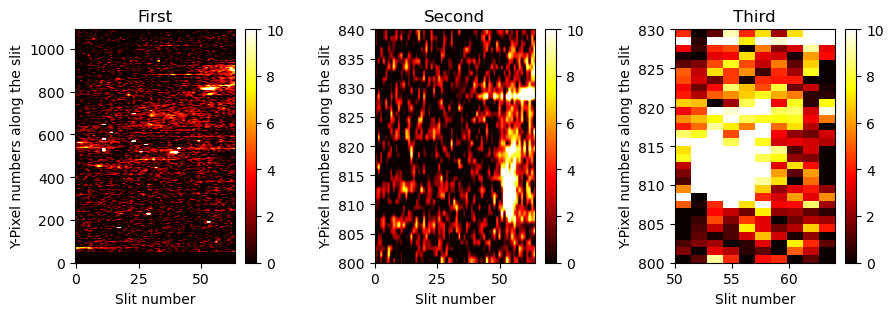

In [44]:
# create figure 
fig = plt.figure(figsize=(10, 7)) 

# setting values to rows and column variables 
rows = 2
columns = 3

# Adds a subplot at the 1st position 
fig.add_subplot(rows, columns, 1) 
  
# showing image 
plt.imshow(win1_c2_sp_data[:,:,162].T, origin='lower', cmap='hot', aspect='auto') 
#plt.axis('off') 
plt.title("First") 
plt.clim(0,10) # colourbar limits
plt.colorbar()
plt.xlabel('Slit number')
plt.ylabel('Y-Pixel numbers along the slit')
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.5, hspace=0.4)

# Adds a subplot at the 2nd position 
fig.add_subplot(rows, columns, 2) 
  
# showing image 
plt.imshow(win1_c2_sp_data[:,800:840,162].T, origin='lower', cmap='hot', aspect='auto', extent=[0,64,800,840]) 
#plt.axis('off') 
plt.title("Second") 
plt.clim(0,10) # colourbar limits
plt.colorbar()
plt.xlabel('Slit number')
plt.ylabel('Y-Pixel numbers along the slit')
  
# Adds a subplot at the 3rd position 
fig.add_subplot(rows, columns, 3) 
  
# showing image 
plt.imshow(win1_c2_sp_data[50:60,800:830,162].T, origin='lower', cmap='hot', aspect='auto', extent=[50,64,800,830]) 
#plt.axis('off') 
plt.title("Third") 
plt.clim(0,10) # colourbar limits
plt.colorbar()
plt.xlabel('Slit number')
plt.ylabel('Y-Pixel numbers along the slit')
plt.show()
  